# **Hypertension Model**

## **Imports**

In [4]:
import math
import os

import joblib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import optuna
import pandas as pd
from pandas.api.types import CategoricalDtype
import seaborn as sns
import shap
import tensorflow as tf
from tqdm.notebook import tqdm
from scipy.stats import norm
import statsmodels.api as sm

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.metrics import AUC
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier 
from xgboost import XGBClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    make_scorer,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    f1_score,
)
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from MLstatkit.stats import Delong_test


In [5]:
import warnings
warnings.filterwarnings('ignore')

## **Data Loading**

In [6]:
df = pd.read_parquet('CG_merged_prs_drugs_anketa_eth.parquet')
df.head()

,ext_sample_id,PGS004604,PGS004603,PGS004605,date,Central-Russia,Bashkiria,Jews,Rejected,Western-Europe,...,steps,work,training,gender,I10,I11,I12,I13,I15,drug_consumption
0,0,5.543380e-07,3.445590e-07,3.464900e-07,2023-06-20 11:25:12.000,70.90,0.0,0.0,0.00,0.00,...,2,1,4,male,0,0,0,0,0,0
1,1,-8.813140e-08,-3.719980e-08,2.946620e-07,2023-06-06 16:09:59.000,49.25,0.0,0.0,0.00,0.00,...,0,1,1,female,0,0,0,0,0,0
2,2,7.245380e-07,8.080290e-07,4.076810e-07,2022-10-07 12:29:57.000,91.48,0.0,0.0,0.75,0.00,...,1,1,1,male,0,0,0,0,0,0
3,3,1.496390e-07,1.934790e-07,1.486880e-07,2022-10-06 09:27:32.000,46.27,0.0,0.0,0.00,3.23,...,2,1,1,female,0,0,0,0,0,0
4,4,3.898210e-07,4.595260e-07,4.810690e-07,2022-11-30 09:54:49.000,22.73,0.0,0.0,1.49,0.00,...,0,1,0,male,0,0,0,0,0,0


In [7]:
df = df.drop(columns=['drugName', 'date'])

## **Exploratory Data Analysis**

We started by removing None values and missing entries from the DataFrame:

In [8]:
print('Initial shape:', df.shape)
df = df[~df.isin(['skipped']).any(axis=1)]
df = df.dropna()
print('Shape after removing None and skipped:', df.shape)

Initial shape: (105385, 42)
Shape after removing None and skipped: (103771, 42)


**Phenotype definition**

The hypertension phenotype was defined based on ICD-10 codes, specifically:

- I10 — Essential (primary) hypertension  
- I11 — Hypertensive heart disease  
- I12 — Hypertensive kidney disease   
- I13 — Hypertensive heart and kidney disease  
- I15 — Secondary hypertension   

In addition to individuals with any of the above diagnoses, we also included participants who reported the use of antihypertensive medications, specifically Metoprolol, Captopril, and Carvedilol.

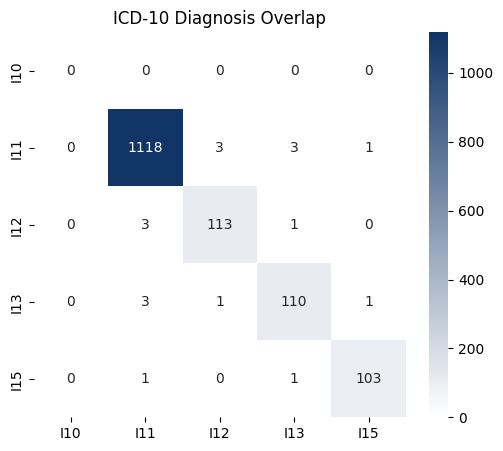

In [9]:
icd_cols = ['I10', 'I11', 'I12', 'I13', 'I15']
icd_data = df[icd_cols].fillna(0).astype(int)
overlap_matrix = icd_data.T.dot(icd_data)
custom_cmap = LinearSegmentedColormap.from_list("custom", ["white",'#113566'])

plt.figure(figsize=(6, 5))
sns.heatmap(overlap_matrix, annot=True, fmt='d', cmap=custom_cmap)
plt.title('ICD-10 Diagnosis Overlap')
plt.show()

In [10]:
df['has_icd'] = df[icd_cols].sum(axis=1) > 0
df['has_drug'] = df['drug_consumption'] == 1

cross_tab = pd.crosstab(
    pd.Categorical(df['has_icd'], categories=[False, True]),
    pd.Categorical(df['has_drug'], categories=[False, True]),
    margins=True
)

cross_tab.index = ['No diagnosis', 'Diagnosis', 'Total']
cross_tab.columns = ['No medication', 'Medication', 'Total']

cross_tab.index.name = None
cross_tab.columns.name = None

cross_tab

,No medication,Medication,Total
No diagnosis,102197,139,102336
Diagnosis,1403,32,1435
Total,103600,171,103771


In [11]:
df['hypertension'] = df['I10'] | df['I11'] | df['I12'] | df['I13'] | df['I15'] | df['drug_consumption']
df = df.drop(columns=['I10', 'I11', 'I12', 'I13', 'I15', 'drug_consumption'])

In [12]:
def column_values_count_percent(column, value_0, value_1, text_0, text_1):
    mapping = {value_0: text_0, value_1: text_1}

    counts = df[column].map(mapping).value_counts()
    percents = df[column].map(mapping).value_counts(normalize=True) * 100

    table = pd.DataFrame({
        'Count': counts,
        'Percent': percents.map('{:.1f}%'.format)
    })
    table.index.name = None
    display(table)

In [13]:
column_values_count_percent('hypertension', 0, 1, 'No Hypertension', 'Hypertension')

,Count,Percent
No Hypertension,102197,98.5%
Hypertension,1574,1.5%


In [14]:
print('All features:\n', df.columns)

All features:
 Index(['ext_sample_id', 'PGS004604', 'PGS004603', 'PGS004605',
       'Central-Russia', 'Bashkiria', 'Jews', 'Rejected', 'Western-Europe',
       'Eastern-Europe', 'Finns', 'Volga', 'Baltic', 'Western-Asia',
       'Central-Asia', 'Siberia', 'Scandinavia', 'Southeastern-Asia',
       'North-Caucasus', 'India', 'Pakistan', 'Southern-Europe', 'America',
       'Aravia', 'Black-Africa', 'Far-East', 'Melanesia', 'smokingStatus',
       'alcoholConsumption', 'education', 'age', 'bmi', 'steps', 'work',
       'training', 'gender', 'has_icd', 'has_drug', 'hypertension'],
      dtype='object')


Then, we separated all features into numerical, categorical, and PRS (Polygenic Risk Score) features:

In [15]:
categorical_features = ['smokingStatus', 'alcoholConsumption', 'education', 'gender', 'steps', 'work', 'training']  
numerical_features = ['age', 'bmi']
prs_features = ['PGS004604', 'PGS004603', 'PGS004605']
ethnic_features = ['Central-Russia', 'Bashkiria', 'Jews', 'Rejected', 'Western-Europe',
                    'Eastern-Europe', 'Finns', 'Volga', 'Baltic', 'Western-Asia',
                    'Central-Asia', 'Siberia', 'Scandinavia', 'Southeastern-Asia',
                    'North-Caucasus', 'India', 'Pakistan', 'Southern-Europe', 'America',
                    'Aravia', 'Black-Africa', 'Far-East', 'Melanesia']

**Categorical Features Overview**

In [16]:
for column in categorical_features:
    print(f'\n--- {column} ---')
    counts = df[column].value_counts()
    percents = df[column].value_counts(normalize=True) * 100

    summary = pd.DataFrame({
        'Count': counts,
        'Percent': percents.map('{:.1f}%'.format)
    })

    print(summary)
    print('_' * 40)


--- smokingStatus ---
               Count Percent
smokingStatus               
never          53252   51.3%
former         31087   30.0%
current        19432   18.7%
________________________________________

--- alcoholConsumption ---
                    Count Percent
alcoholConsumption               
1.0                 36941   35.6%
2.0                 32749   31.6%
0.0                 14989   14.4%
3.0                 14520   14.0%
4.0                  4572    4.4%
________________________________________

--- education ---
              Count Percent
education                  
college       73196   70.5%
secondary     14773   14.2%
school         9211    8.9%
postgraduate   6312    6.1%
preschool       279    0.3%
________________________________________

--- gender ---
        Count Percent
gender               
female  57716   55.6%
male    46055   44.4%
________________________________________

--- steps ---
       Count Percent
steps               
1      50143   48.3%
0    

**Numerical Features Overview**

In [17]:
def describe_with_quartiles(data):
    q1 = np.percentile(data, 25)
    median = np.median(data)
    q3 = np.percentile(data, 75)
    return median, q1, q3, f'{median:.2f} [{q1:.2f}; {q3:.2f}]'

def describe_numeric_features(df, numerical_features):
    for col in numerical_features:
        series = df[col].dropna()
        
        median, q1, q3, formatted = describe_with_quartiles(series)
        print(f"{col}: {formatted}")

In [18]:
describe_numeric_features(df, numerical_features)

age: 40.00 [35.00; 49.00]
bmi: 24.34 [21.45; 27.76]


**Visualization**

In [58]:
plot_dir = 'hypertension_plots'

if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

In [20]:
def apply_category_order(df: pd.DataFrame) -> pd.DataFrame:
    category_orders = {
        'education': ['preschool', 'school', 'secondary', 'college', 'postgraduate'],
        'smoking_status': ['never', 'former', 'current']
    }

    for col, order in category_orders.items():
        if col in df.columns:
            dtype = CategoricalDtype(categories=order, ordered=True)
            df[col] = df[col].astype(dtype)

    return df

In [21]:
df = apply_category_order(df)

In [22]:
def draw_cat_distr(df: pd.DataFrame, cat_features: list[str]):
    num_plots = len(cat_features)
    plots_per_row = 2
    num_rows = math.ceil(num_plots / plots_per_row)

    fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(3.5 * plots_per_row, 3.5 * num_rows), squeeze=False)
    axes = axes.flatten()
 
    for i, feature in enumerate(cat_features):
        percentages = (
            df.groupby('hypertension')[feature]
            .value_counts(normalize=True)
            .mul(100)
            .rename('percentage')
            .reset_index()
        )
        pivot_data = percentages.pivot(index=feature, columns='hypertension', values='percentage')

        ax = axes[i] 
        bars = pivot_data.plot(kind='bar', stacked=False, ax=ax, width=0.8, color=['#889AB3', '#FF8282'])

        ax.set_title(f'{feature}')
        ax.set_xlabel(feature)
        ax.set_ylabel('Percentage')
        ax.tick_params(axis='x', rotation=45)
        ax.get_legend().remove()  

    for j in range(num_plots, len(axes)):
        fig.delaxes(axes[j])

    fig.legend(['Healthy', 'Hypertension'], loc='upper center', ncol=2, fontsize=12)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(os.path.join(plot_dir, 'categorical_distribution.png'), dpi=300)
    plt.show()

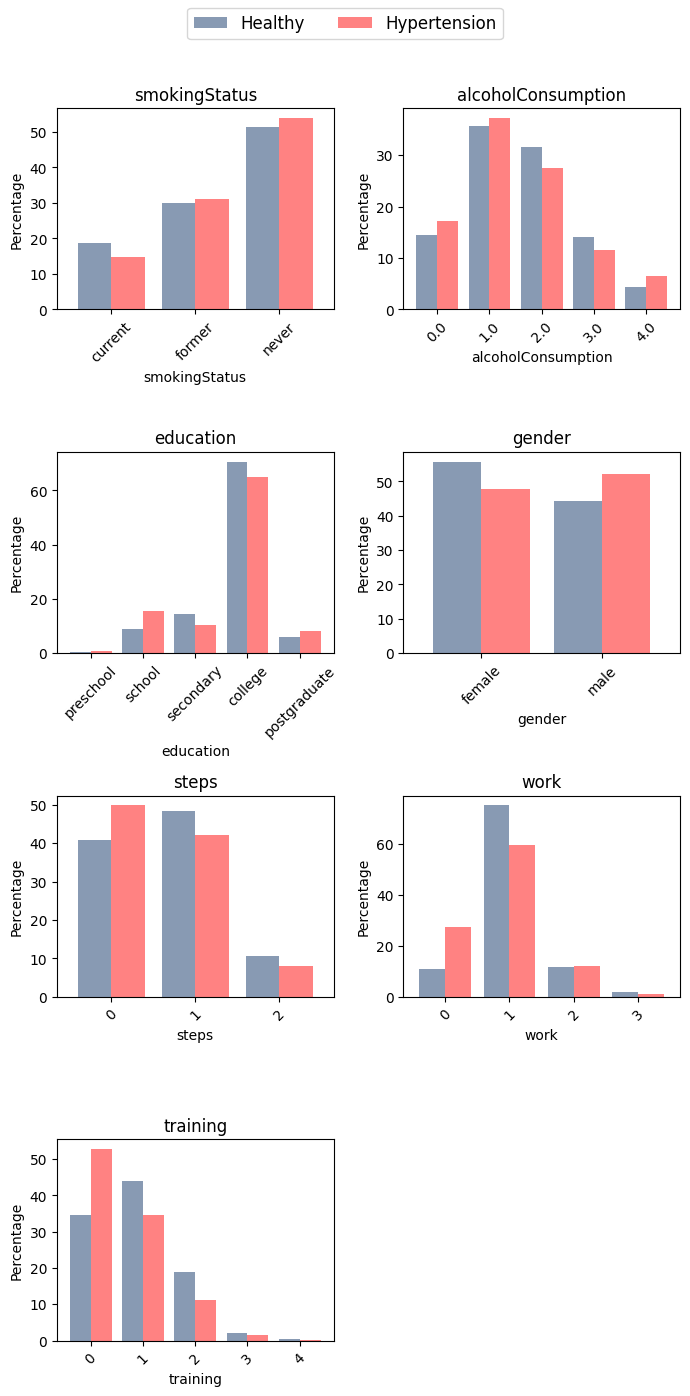

In [23]:
draw_cat_distr(df, categorical_features)

In [24]:
def draw_2_y_axes_plots_with_ci(df, category_cols):
    num_plots = len(category_cols)
    plots_per_row = 2
    num_rows = math.ceil(num_plots / plots_per_row)

    fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(4 * plots_per_row, 3.5 * num_rows))
    axes = axes.flatten()

    all_handles, all_labels = None, None

    for i, cat_col in enumerate(category_cols):  
        cat_group = df.groupby([cat_col, 'hypertension']).size().unstack(fill_value=0)

        cat_group_total = cat_group.sum(axis=1)
        cat_group_percentage = (cat_group[1] / cat_group_total) * 100

        ci_lower, ci_upper = [], []
        for count, total in zip(cat_group[1], cat_group_total):
            if total > 0:  
                p = count / total
                se = np.sqrt(p * (1 - p) / total)
                ci = norm.ppf(0.975) * se
                ci_lower.append((p - ci) * 100)
                ci_upper.append((p + ci) * 100)
            else:
                ci_lower.append(0)
                ci_upper.append(0)

        ax = axes[i]
        x = range(len(cat_group_percentage))

        ax2 = ax.twinx()
        bar = ax.bar(x, cat_group_total, color='#FF8282',  label='Total Count', zorder=1)
        ax.set_ylabel('Total Count', color='#FF8282')
        ax.set_yscale('log')
        ax.set_ylim(1, max(cat_group_total.max() * 1.5, 10))

        line = ax2.plot(x, cat_group_percentage, color='#113566', marker='o', label='Hypertension (%)', zorder=4, linewidth=3)
        fill = ax2.fill_between(x, ci_lower, ci_upper, color='#113566', alpha=0.3, label='95% CI', zorder=3)
        ax2.set_ylabel('Percentage of Hypertension', color='#113566')
        ax2.set_ylim(0, max(max(ci_upper) * 1.2, 10))

        ax2.set_title(f'{cat_col} vs Hypertension')
        
        ax2.set_xticks(x)
       
        ax2.set_xticklabels(cat_group.index, rotation=45, ha='right')
        ax2.tick_params(axis='x', labelrotation=45)

        ax.set_xticks(x)
        ax.set_xticklabels([str(label) for label in cat_group.index], rotation=45, ha='right')

        if all_handles is None:
            handles1, labels1 = ax.get_legend_handles_labels()
            handles2, labels2 = ax2.get_legend_handles_labels()
            all_handles = handles1 + handles2
            all_labels = labels1 + labels2

    for j in range(num_plots, len(axes)):
        fig.delaxes(axes[j])

    fig.legend(all_handles, all_labels, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.02), fontsize=11)

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.savefig(os.path.join(plot_dir, 'ci_distribution.png'), dpi=300)
    plt.show()

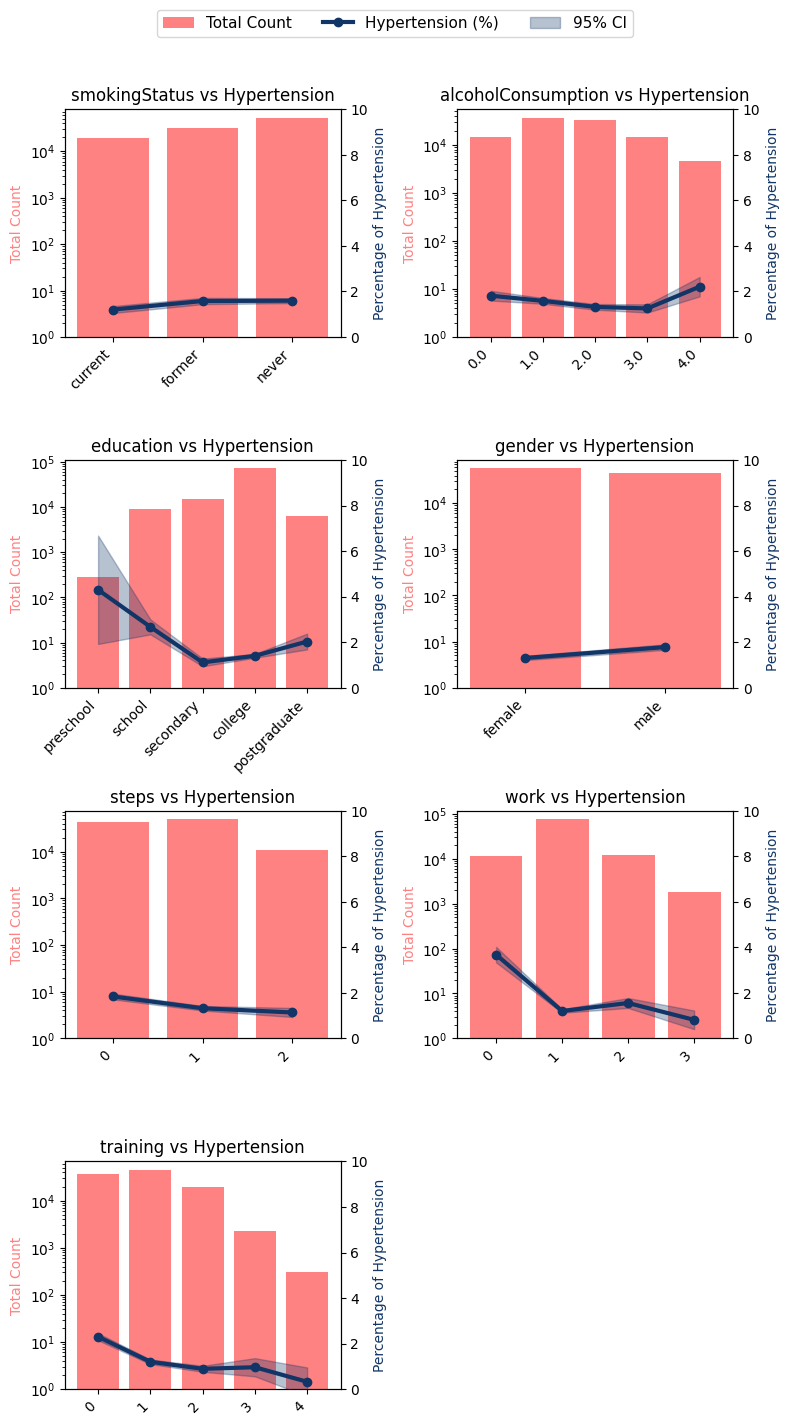

In [25]:
draw_2_y_axes_plots_with_ci(df, categorical_features)

In [26]:
# two-factor analysis
def plot_heatmap_mean_and_count(df, feature1, feature2, target):
    mean_target = df.groupby([feature1, feature2])[target].mean().unstack()
    count_target = df.groupby([feature1, feature2])[target].count().unstack()

    plt.figure(figsize=(6, 6))
    custom_cmap = LinearSegmentedColormap.from_list("custom", ['#889AB3', 'white', '#FF8282'])
    ax = sns.heatmap(mean_target, annot=False, fmt='.2f', cmap=custom_cmap, cbar=True, vmin=0, vmax=0.03)

    for i in range(mean_target.shape[0]):
        for j in range(mean_target.shape[1]):
            mean_val = mean_target.iloc[i, j]
            count_val = count_target.iloc[i, j]
            ax.text(
                j + 0.5,  
                i + 0.5,  
                f'{mean_val:.3f}\n({int(count_val)})', 
                ha='center', va='center', color='black'
            )

    plt.title(f'Heatmap of mean {target} and count by {feature1} and {feature2}')
    plt.xlabel(feature2)
    plt.ylabel(feature1)
    plt.tight_layout()
    plt.show()

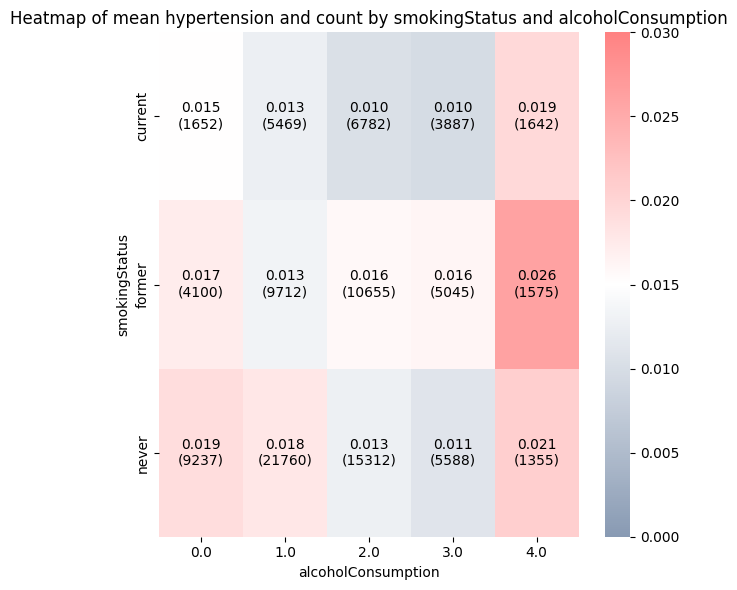

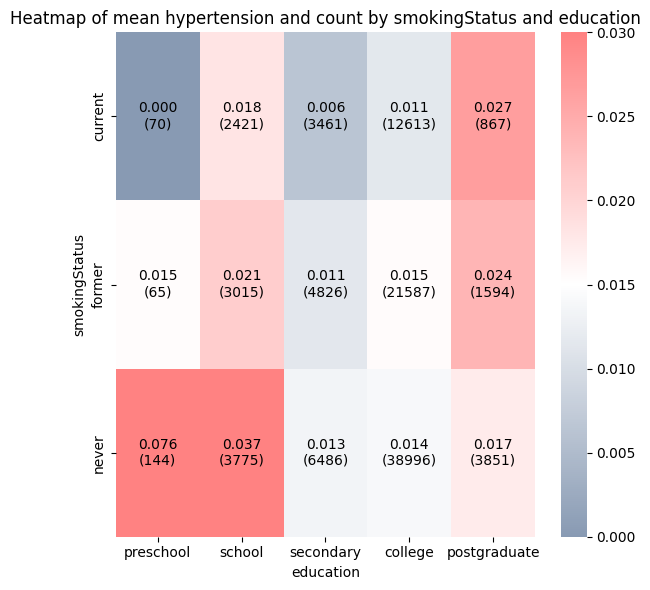

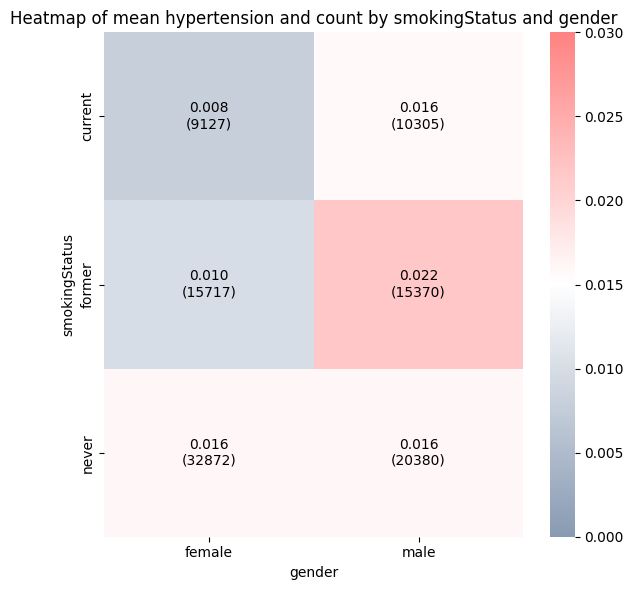

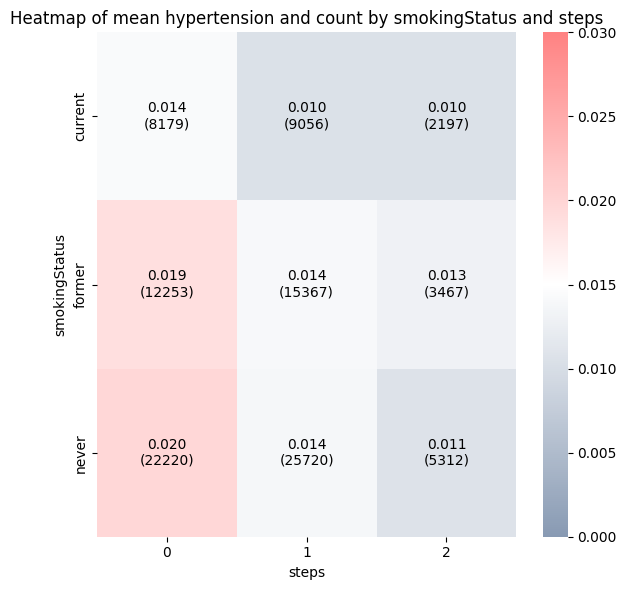

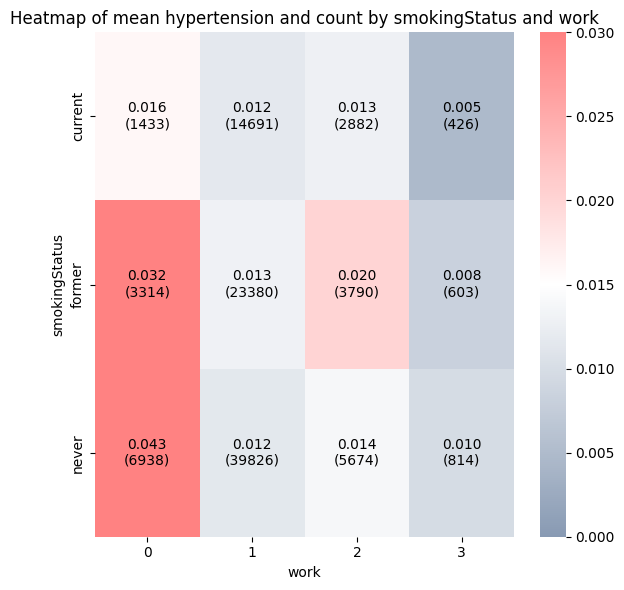

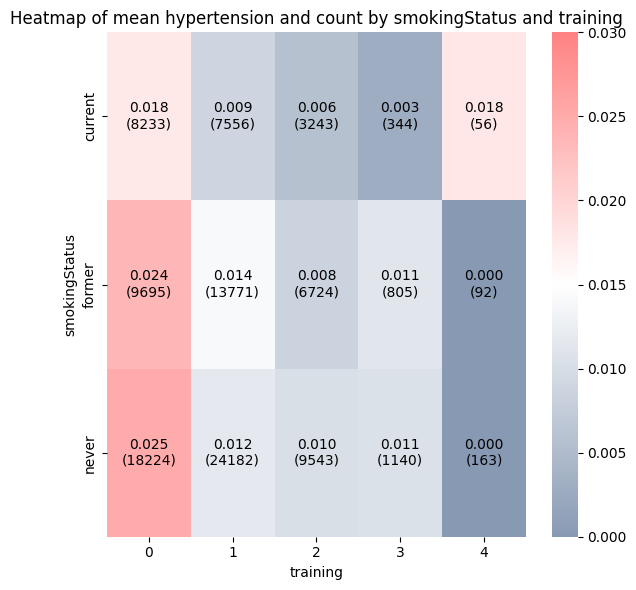

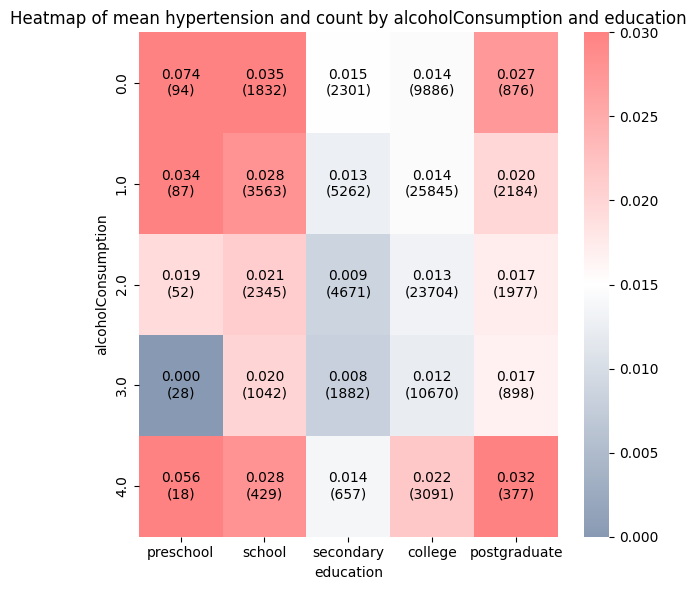

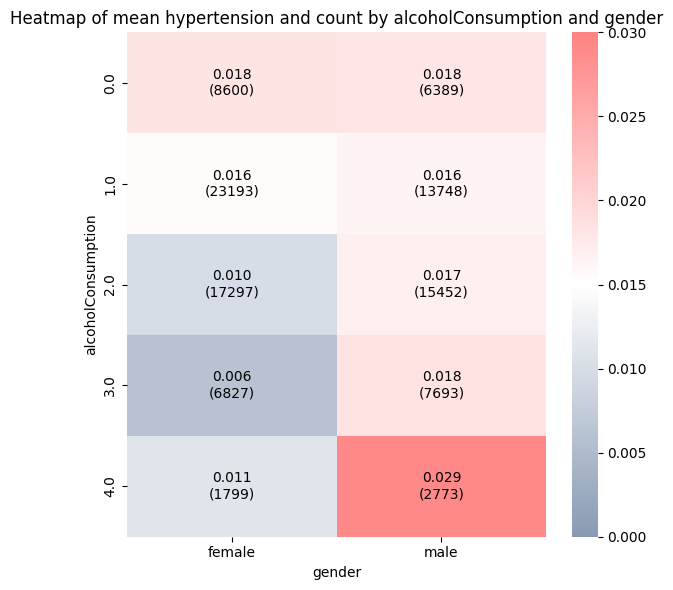

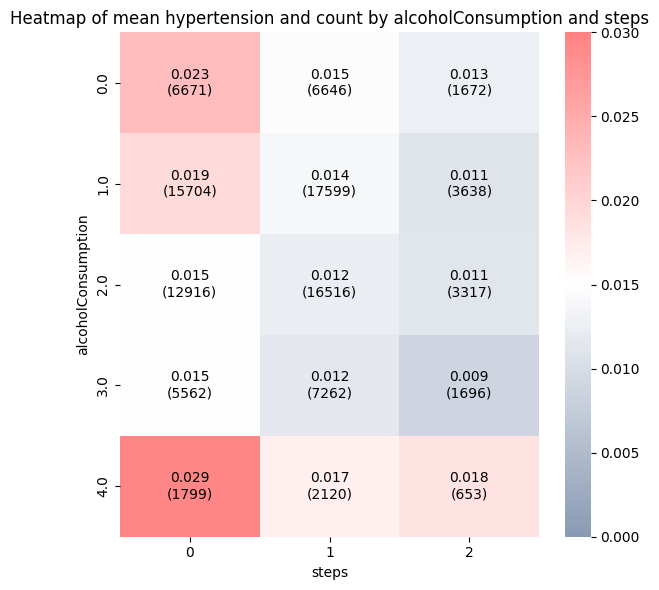

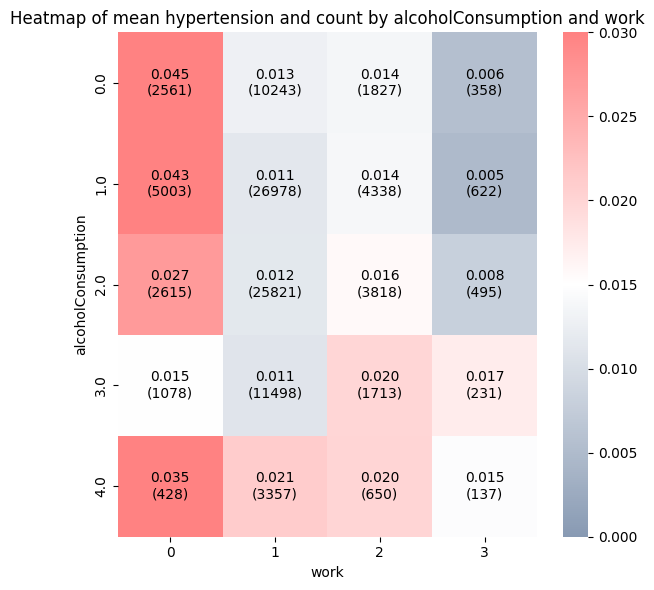

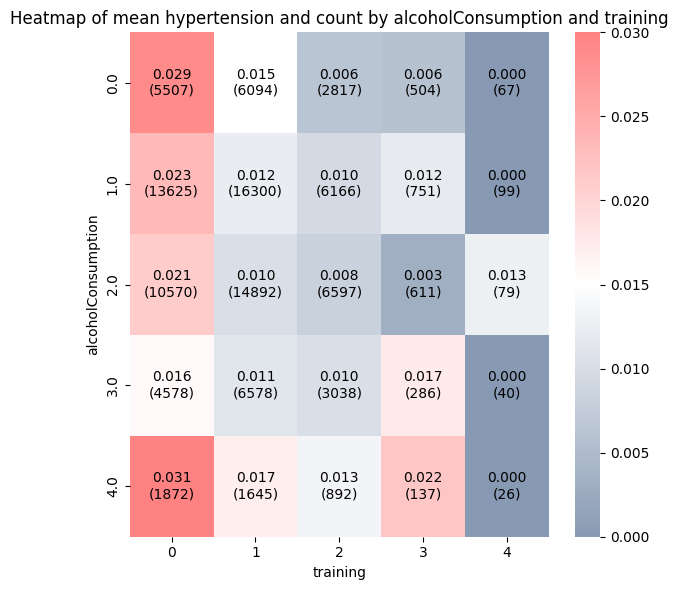

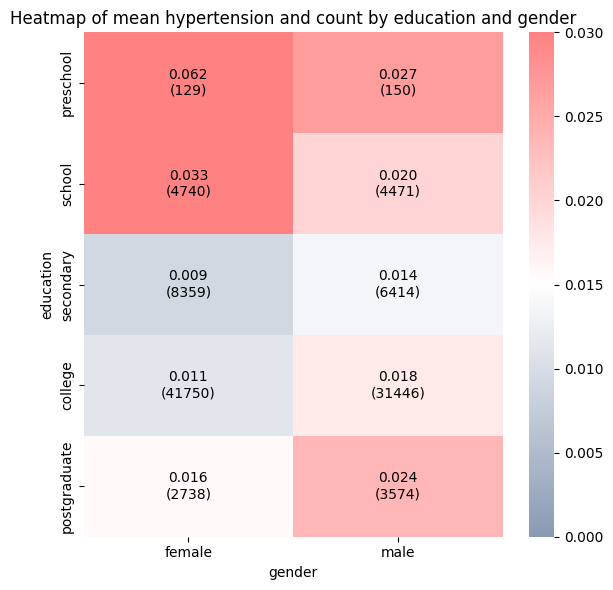

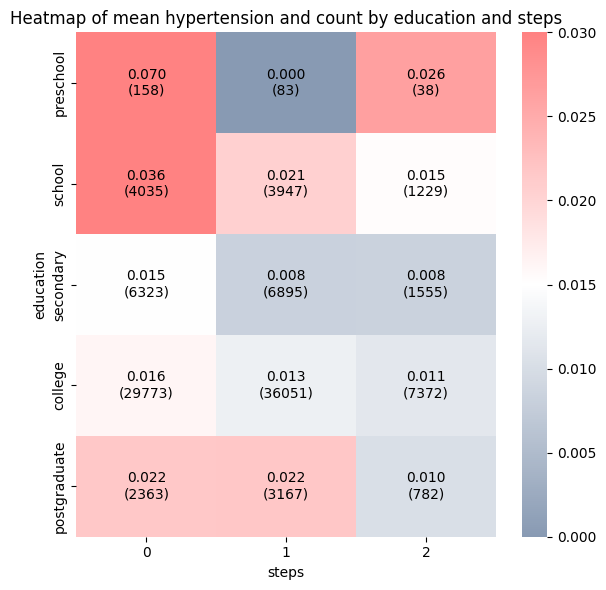

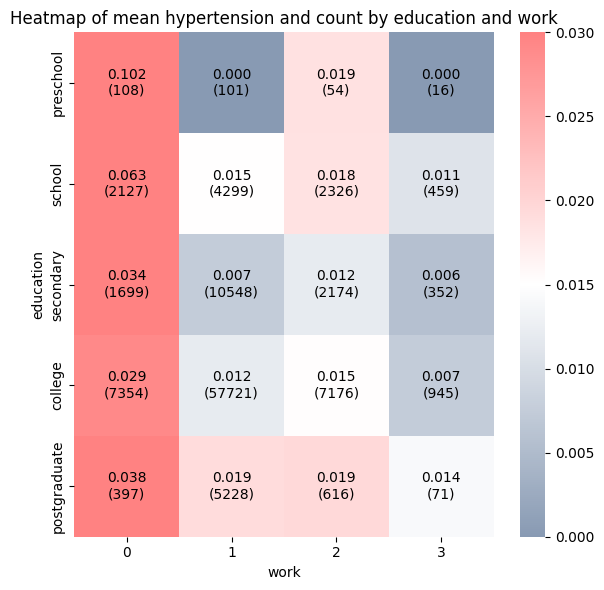

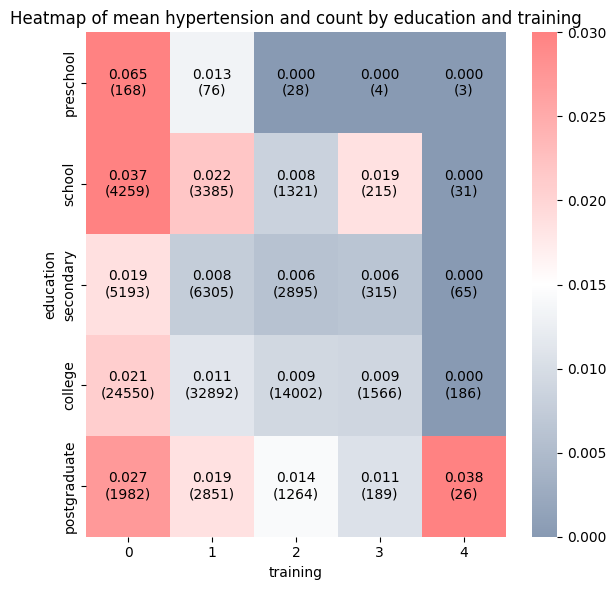

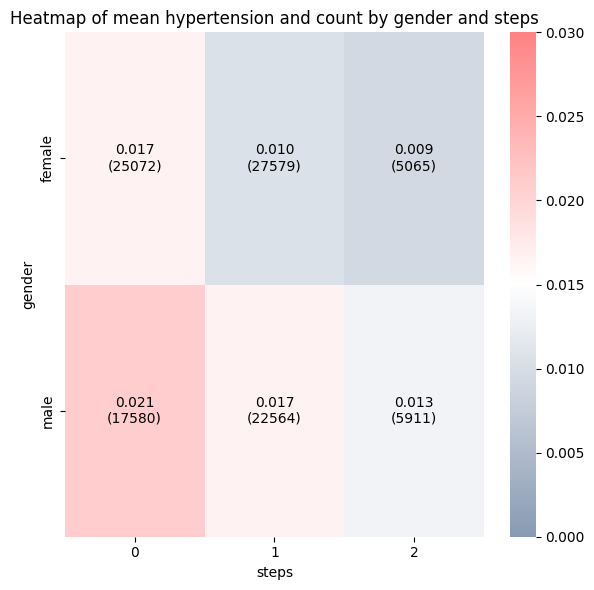

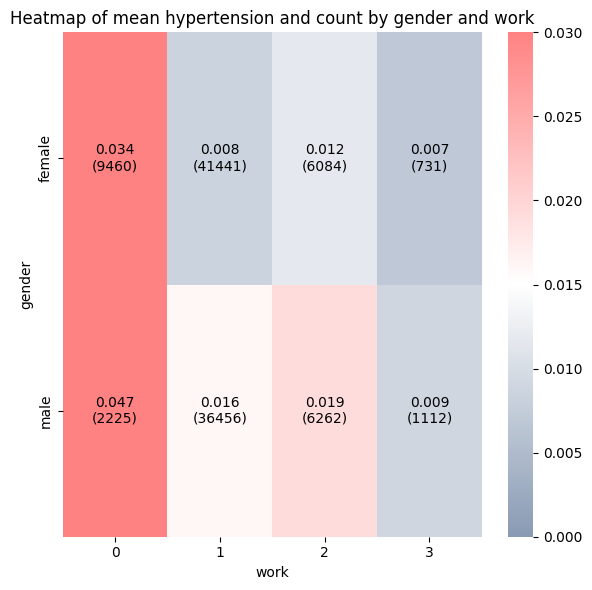

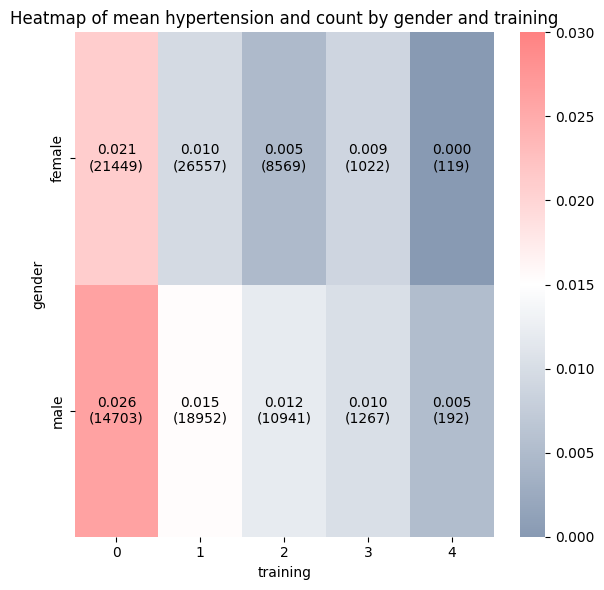

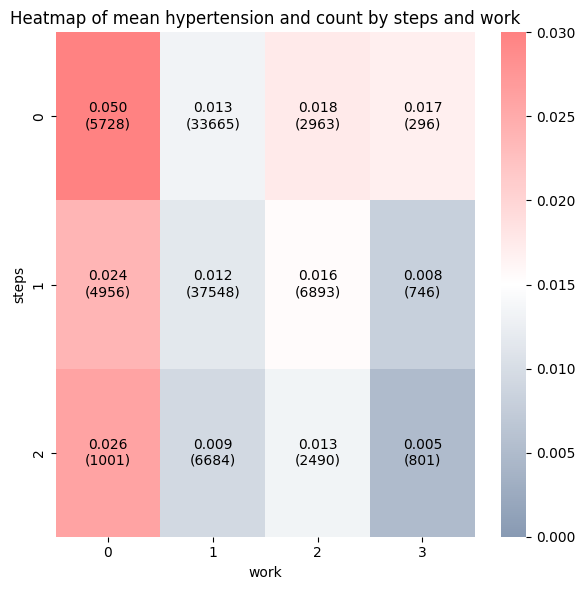

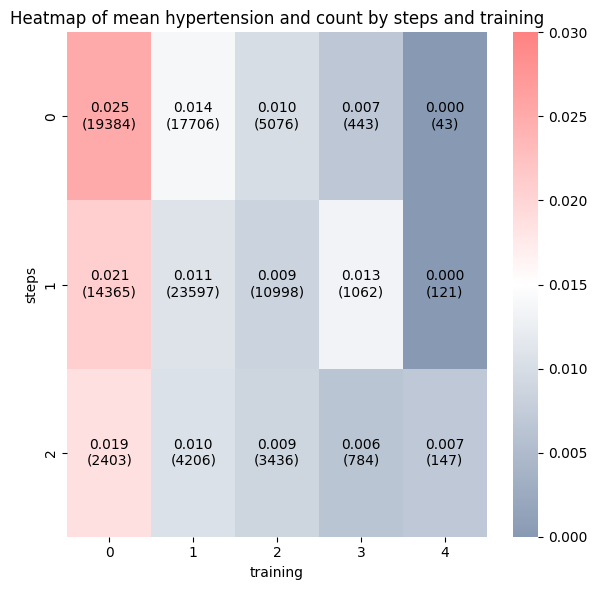

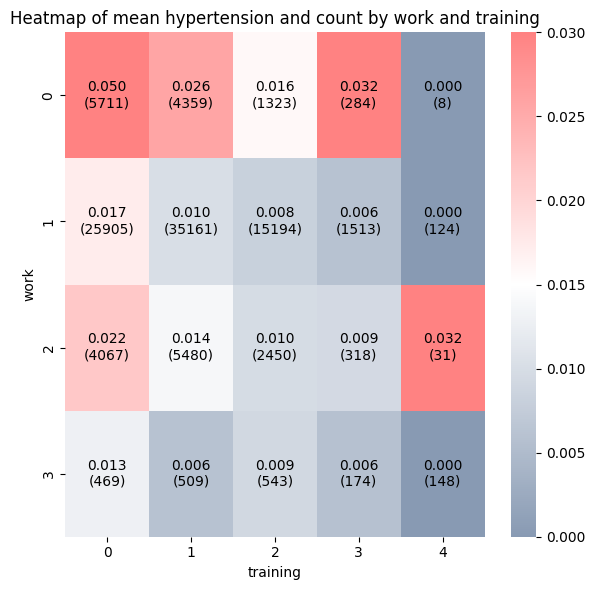

In [27]:
for i in range(len(categorical_features)):
    for j in range(i+1, len(categorical_features)):
        plot_heatmap_mean_and_count(df, categorical_features[i], categorical_features[j], 'hypertension')

In [28]:
df['gender'] = df['gender'].replace({'female': 0, 'male': 1})

df['smokingStatus'].fillna('never', inplace=True)
df['smokingStatus'].replace({'never': 0, 'former': 1, 'current': 2}, inplace=True)

In [29]:
def draw_columns_histplots(df, color):
    num_columns = len(df.columns)
    num_rows = math.ceil(num_columns / 2) 

    fig, axes = plt.subplots(num_rows, 2, figsize=(9, 3 * num_rows))
    axes = axes.flatten() 

    for i, column in enumerate(df.columns):
        sns.histplot(df[column], kde=True, bins=60, color=color, ax=axes[i])
        axes[i].set_title(f'Histogram of {column}')

    for j in range(len(df.columns), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.savefig(os.path.join(plot_dir, 'numerical_distribution.png'), dpi=300)
    plt.show()

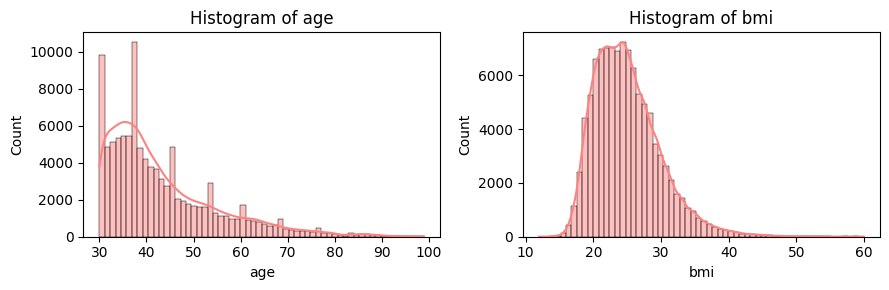

In [30]:
draw_columns_histplots(df[numerical_features], '#FF8282')

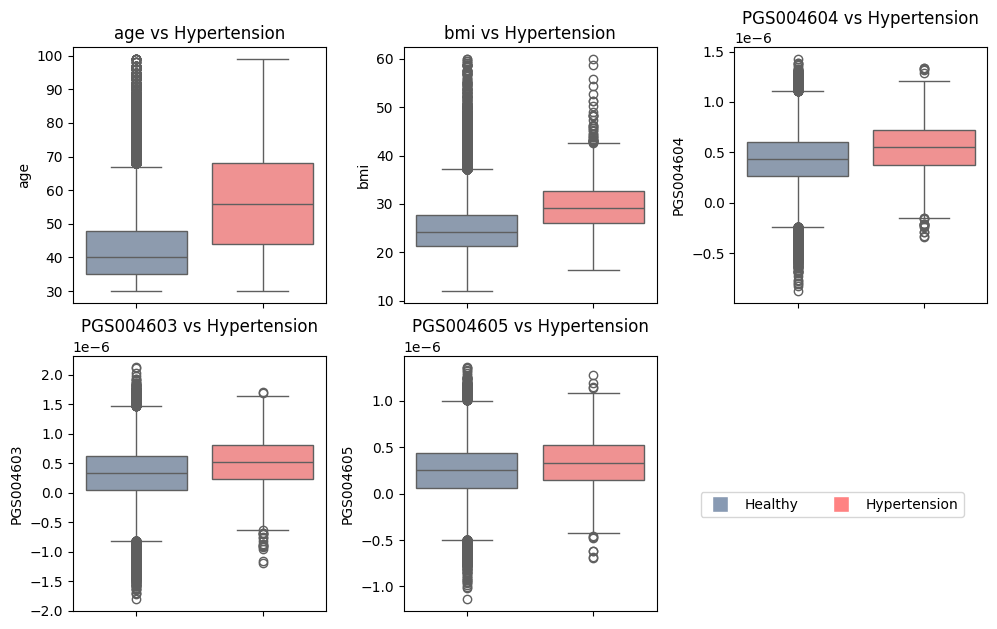

In [31]:
features = numerical_features + prs_features
n_rows = (len(features) + 2) // 3  
fig, axes = plt.subplots(n_rows, 3, figsize=(10, 7))

palette = {'0': '#889AB3', '1': '#FF8282'}
labels_map = {'0': 'Healthy', '1': 'Hypertension'}

for i, feature in enumerate(features):
    ax = axes[i // 3, i % 3] if n_rows > 1 else axes[i % 3]
    sns.boxplot(x='hypertension', y=feature, data=df, ax=ax, palette=palette)
    ax.set_title(f'{feature} vs Hypertension')
    ax.set_xlabel('Hypertension')
    ax.set_ylabel(feature)
    ax.set_xticklabels([])
    ax.set_xlabel('')

for j in range(len(features), n_rows * 3):
    ax = axes[j // 3, j % 3] if n_rows > 1 else axes[j % 3]
    ax.axis('off')


handles = [
    plt.Line2D([0], [0], marker='s', color='w', label=labels_map[k],
               markerfacecolor=v, markersize=12)
    for k, v in palette.items()
]

fig.legend(handles=handles, loc='upper center', ncol=2, bbox_to_anchor=(0.83, 0.3))
plt.tight_layout()
plt.subplots_adjust(bottom=0.12)  
plt.savefig(os.path.join(plot_dir, 'boxplots.png'), dpi=300)
plt.show()

To enhance the feature set, we created additional features by calculating polynomial terms and interactions between existing features:

In [32]:
df['age_bmi'] = df['age'] * df['bmi']

df['PGS604_603'] = df['PGS004604'] * df['PGS004603']
df['PGS604_605'] = df['PGS004604'] * df['PGS004605']
df['PGS603_605'] = df['PGS004603'] * df['PGS004605']

df['bad_habits'] = (df['smokingStatus'] == 2) | (df['alcoholConsumption'] > 1)

In [33]:
column_values_count_percent('bad_habits', False, True, 'No Bad Habits', 'Bad Habits')

,Count,Percent
Bad Habits,58962,56.8%
No Bad Habits,44809,43.2%


In [34]:
print('Current columns:\n', df.columns)

Current columns:
 Index(['ext_sample_id', 'PGS004604', 'PGS004603', 'PGS004605',
       'Central-Russia', 'Bashkiria', 'Jews', 'Rejected', 'Western-Europe',
       'Eastern-Europe', 'Finns', 'Volga', 'Baltic', 'Western-Asia',
       'Central-Asia', 'Siberia', 'Scandinavia', 'Southeastern-Asia',
       'North-Caucasus', 'India', 'Pakistan', 'Southern-Europe', 'America',
       'Aravia', 'Black-Africa', 'Far-East', 'Melanesia', 'smokingStatus',
       'alcoholConsumption', 'education', 'age', 'bmi', 'steps', 'work',
       'training', 'gender', 'has_icd', 'has_drug', 'hypertension', 'age_bmi',
       'PGS604_603', 'PGS604_605', 'PGS603_605', 'bad_habits'],
      dtype='object')


Now we update the lists of numerical and categorical features:

In [35]:
numerical_features = ['smokingStatus', 'alcoholConsumption', 'age', 'bmi', 'steps', 
                      'work', 'training', 'gender', 'PGS004604', 'PGS004603', 'PGS004605', 
                      'age_bmi', 'PGS604_603', 'PGS604_605', 'PGS603_605', 'bad_habits']
categorical_features = ['education']

We used an encoder to transform categorical features and computed the correlation matrix:

In [36]:
encoder = OneHotEncoder(drop='first', sparse_output=False)
one_hot_encoded = encoder.fit_transform(df[categorical_features])
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_features))
df_encoded = pd.concat([df[numerical_features+categorical_features].drop(columns=categorical_features), one_hot_df], axis=1)

In [37]:
def draw_corr_matrix(df):
    corr_matrix = df.corr()

    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    corr_matrix_filtered = corr_matrix.where(abs(corr_matrix) > 0.7)
    custom_cmap = LinearSegmentedColormap.from_list("custom", ['#889AB3', 'white', '#FF8282'])

    plt.figure(figsize=(18, 9))
    sns.heatmap(corr_matrix_filtered, annot=True, cmap=custom_cmap, vmin=-1, vmax=1, center=0, mask=mask, linewidths=.5, cbar_kws={'shrink': .5})
    plt.title('Correlation Matrix (|corr| > 0.7)')
    plt.tight_layout()
    plt.savefig(os.path.join(plot_dir, 'corr_matrix.png'), dpi=300)
    plt.show()

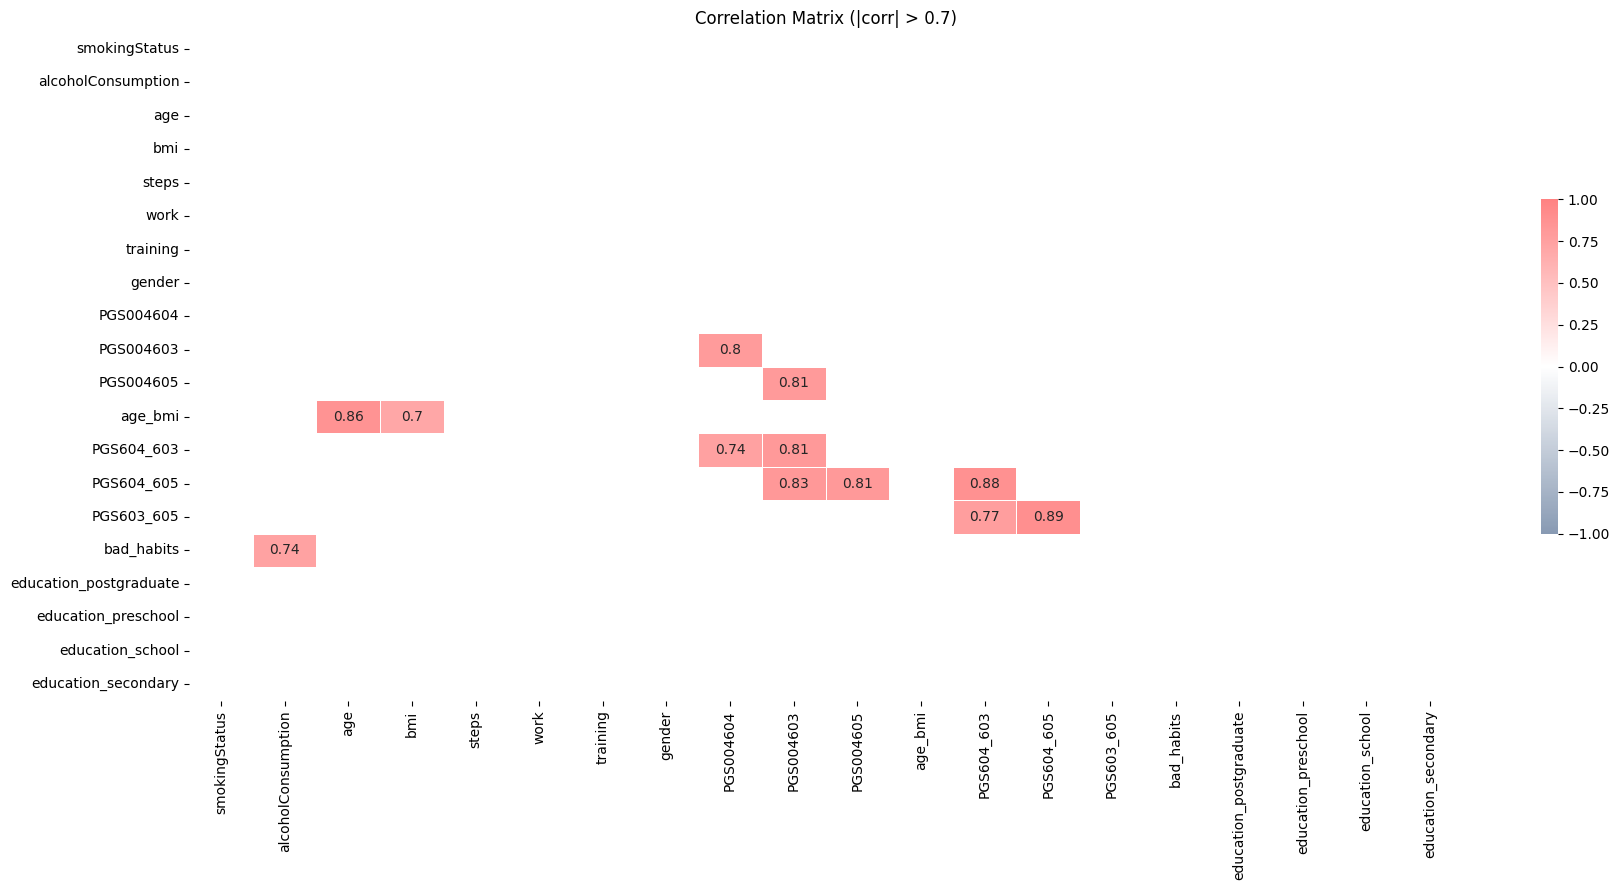

In [38]:
draw_corr_matrix(df_encoded)

**IV (Information Value) и WOE (Weight of Evidence)**

In [39]:
X = df.drop(columns=['hypertension'])
y = df['hypertension']

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [41]:
df_train = pd.concat([X_train, y_train], axis=1)

In [42]:
print("Current columns:\n", df.columns)

Current columns:
 Index(['ext_sample_id', 'PGS004604', 'PGS004603', 'PGS004605',
       'Central-Russia', 'Bashkiria', 'Jews', 'Rejected', 'Western-Europe',
       'Eastern-Europe', 'Finns', 'Volga', 'Baltic', 'Western-Asia',
       'Central-Asia', 'Siberia', 'Scandinavia', 'Southeastern-Asia',
       'North-Caucasus', 'India', 'Pakistan', 'Southern-Europe', 'America',
       'Aravia', 'Black-Africa', 'Far-East', 'Melanesia', 'smokingStatus',
       'alcoholConsumption', 'education', 'age', 'bmi', 'steps', 'work',
       'training', 'gender', 'has_icd', 'has_drug', 'hypertension', 'age_bmi',
       'PGS604_603', 'PGS604_605', 'PGS603_605', 'bad_habits'],
      dtype='object')


In [43]:
bins_columns = ['smokingStatus', 'alcoholConsumption', 'education', 'bad_habits', 'steps', 'work', 'training', 'gender']
create_bins_columns = ['age', 'bmi', 'PGS004604', 'PGS004603', 'PGS004605', 'age_bmi', 'PGS604_603', 'PGS604_605', 'PGS603_605']

In [44]:
def bin_numerical_feature_by_percentile(data, feature, q=10):
    bins = np.quantile(data[feature], q=np.linspace(0, 1, q + 1))
    feature = pd.cut(data[feature], bins=bins, include_lowest=True, duplicates='drop')
    return feature

In [45]:
for col in create_bins_columns:
    binned = bin_numerical_feature_by_percentile(df_train, col)
    df_train[f'binned_{col}'] = binned

In [46]:
def calculate_woe_iv(data, target, feature):
    grouped = data.groupby(feature)[target].agg(['count', 'sum'])
    grouped = grouped.rename(columns={'sum': 'event', 'count': 'total'})

    grouped['non_event'] = grouped['total'] - grouped['event']
    grouped['event_rate'] = grouped['event'] / grouped['event'].sum()
    grouped['non_event_rate'] = grouped['non_event'] / grouped['non_event'].sum()
    grouped['woe'] = np.log(grouped['event_rate'] / grouped['non_event_rate'])
    grouped['iv'] = (grouped['event_rate'] - grouped['non_event_rate']) * grouped['woe']

    grouped.replace([np.inf, -np.inf], 0, inplace=True)

    iv = grouped['iv'].sum()

    return iv

In [47]:
iv_df = pd.DataFrame(columns=['column_name', 'iv'])

for column in create_bins_columns:
    binned_col = f'binned_{column}'
    iv = calculate_woe_iv(df_train.copy(), target='hypertension', feature=binned_col)
    iv_df = pd.concat([iv_df, pd.DataFrame([{'column_name': binned_col, 'iv': iv}])], ignore_index=True)

for column in bins_columns:
    iv = calculate_woe_iv(df_train.copy(), target='hypertension', feature=column)
    iv_df = pd.concat([iv_df, pd.DataFrame([{'column_name': column, 'iv': iv}])], ignore_index=True)

In [48]:
iv_df.sort_values(by='iv', ascending=False, inplace=True)
print('Information Value (IV)')
iv_df

Information Value (IV)


,column_name,iv
5,binned_age_bmi,1.435765
1,binned_bmi,0.944785
0,binned_age,0.912567
2,binned_PGS004604,0.201420
6,binned_PGS604_603,0.194612
14,work,0.185727
3,binned_PGS004603,0.179497
7,binned_PGS604_605,0.160199
15,training,0.155045
8,binned_PGS603_605,0.118487


Based on the Information Value (IV) analysis, we retained all features with an IV score above 0.1 (or close to it — as in the case of binned_PGS004605, which had an IV of 0.09) for further modeling. 

In [49]:
df = df.drop(columns=['education', 'gender', 'steps', 'alcoholConsumption', 'smokingStatus', 'bad_habits'])

**Odds Ratio (OR)**

In [50]:
def create_deciles(df, column):
    df[f'{column}_decile'] = pd.qcut(df[column], 10, labels=False) + 1
    return df

In [51]:
def calculate_or(df, decile_column, decile, a_ref, b_ref, target_column='hypertension'):
    df['is_target_decile'] = (df[decile_column] == decile).astype(int)  

    a = ((df['is_target_decile'] == 1) & (df[target_column] == 1)).sum()
    b = ((df['is_target_decile'] == 1) & (df[target_column] == 0)).sum()

    or_value = a * b_ref / (b * a_ref)
    se = np.sqrt(1/a + 1/b + 1/a_ref + 1/b_ref)
    ci = [np.exp(np.log(or_value) - 1.96 * se), np.exp(np.log(or_value) + 1.96 * se)]
    
    return or_value, ci

In [64]:
def plot_or(df, prs_columns, target_column='hypertension'):
    fig, axes = plt.subplots(1, 3, figsize=(6, 5), sharey=True)
    name_map = {
        'PGS004604': 'DBP',
        'PGS004603': 'SBP',
        'PGS004605': 'PP'
    }

    for i, prs_column in enumerate(prs_columns):
        df = create_deciles(df, prs_column)

        a_ref = ((df[f'{prs_column}_decile'] == 1) & (df[target_column] == 1)).sum()
        b_ref = ((df[f'{prs_column}_decile'] == 1) & (df[target_column] == 0)).sum()

        deciles = range(1, 11)
        or_values = []
        lower_bounds = []
        upper_bounds = []

        for decile in deciles:
            or_value, ci = calculate_or(df, f'{prs_column}_decile', decile, a_ref, b_ref)
            or_values.append(or_value)
            if decile != 1:
                lower_bounds.append(ci[0])
                upper_bounds.append(ci[1])

        prs_label = name_map.get(prs_column, prs_column)
        ax = axes[i]

        ax.plot(deciles, or_values, marker='o', label=f'OR for {prs_label}', color='#113566')
        ax.fill_between(deciles[1:], lower_bounds, upper_bounds, color='#113566', alpha=0.2, label='95% CI')
        ax.set_title(f'{prs_label} PRS')
        ax.set_xlabel('PRS Deciles')
        if i == 0:
            ax.set_ylabel('Odds Ratio for Hypertension')

        ax.axhline(1, color='red', linestyle='--', linewidth=0.8)
        ax.set_xticks(deciles)
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1.5))
        ax.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.3)
        ax.legend()

    plt.suptitle('Odds Ratios by PRS Deciles', fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(os.path.join(plot_dir, 'PRS_OR_all.png'), dpi=300)
    plt.show()

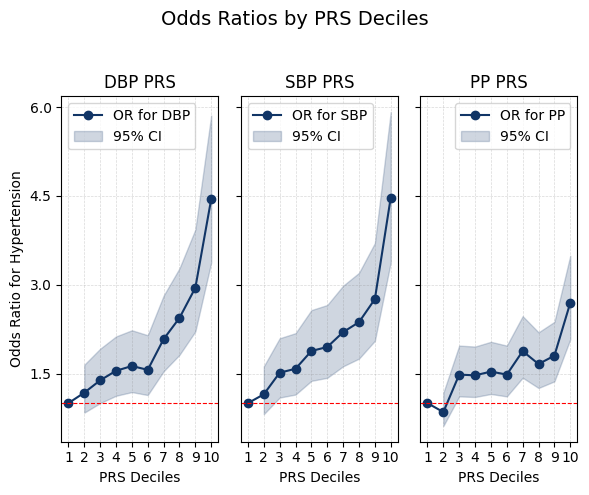

In [65]:
plot_or(df_train, prs_features) 

## **Model Training and Evaluation**

### **Functions**

In [719]:
class TQDMProgressBar(optuna.study.Study):
    def __init__(self, n_trials):
        self.pbar = tqdm(total=n_trials)

    def __call__(self, study, trial):
        self.pbar.update(1)

    def close(self):
        self.pbar.close()

In [720]:
def sfs_features(model, X_train, y_train):
    sfs = SequentialFeatureSelector(
        model,
        scoring=make_scorer(roc_auc_score, needs_proba=True),  
        n_features_to_select='auto',  
        direction='backward'  
    )
    sfs.fit(X_train, y_train)

    return X_train.columns[sfs.get_support()]

In [721]:
def skfold_cross_val(X, y, model, scaler_flag=False, scaler=None, numerical_features=None, model_coefs_flag=True):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    test_auc_scores = []
    train_auc_scores = []
    model_coefs = []

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        if scaler_flag:
            X_train_scaled = X_train.copy()
            X_test_scaled = X_test.copy()
            X_train_scaled[numerical_features] = scaler.fit_transform(X_train[numerical_features])
            X_test_scaled[numerical_features] = scaler.transform(X_test[numerical_features])
        else:
            X_train_scaled = X_train
            X_test_scaled = X_test

        model.fit(X_train_scaled, y_train)

        if model_coefs_flag:
            model_coefs.append(model.coef_)

        y_train_prob = model.predict_proba(X_train_scaled)[:, 1]
        y_test_prob = model.predict_proba(X_test_scaled)[:, 1]

        train_auc_scores.append(roc_auc_score(y_train, y_train_prob))
        test_auc_scores.append(roc_auc_score(y_test, y_test_prob))
    if model_coefs_flag:
        return np.array(train_auc_scores), np.array(test_auc_scores), model_coefs
    return np.array(train_auc_scores), np.array(test_auc_scores)

In [722]:
def train_evaluate(X, y, model, scaler_flag=False, scaler=None, numerical_features=None):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    if scaler_flag:
        X_train_scaled = X_train.copy()
        X_test_scaled = X_test.copy()
        X_train_scaled[numerical_features] = scaler.fit_transform(X_train[numerical_features])
        X_test_scaled[numerical_features] = scaler.transform(X_test[numerical_features])
    else:
        X_train_scaled = X_train
        X_test_scaled = X_test

    model.fit(X_train_scaled, y_train)

    y_train_prob = model.predict_proba(X_train_scaled)[:, 1]
    y_test_prob = model.predict_proba(X_test_scaled)[:, 1]

    train_auc = roc_auc_score(y_train, y_train_prob)
    test_auc = roc_auc_score(y_test, y_test_prob)
    
    return train_auc, test_auc, y_test, y_test_prob, model

In [723]:
def print_train_test_results(train, test, text):
    print(f'Train Roc-Auc {text}: {train:.4f}')
    # print(f'Train Mean Roc-Auc {text}: {train.mean():.4f}\n')

    print(f'Test Roc-Auc {text}: {test:.4f}')
    # print(f'Test Mean Roc-Auc {text}: {test.mean():.4f}')

In [729]:
def add_to_results(df_results, model_description, train_auc, test_auc):
    df_results.loc[len(df_results)] = {
        'model': model_description,
        'train_auc': train_auc,
        'test_auc': test_auc
    }

    return df_results

In [724]:
def sort_print_model_coef(model_coefs, shape_0, shape_1, column_names, model_name):
    coefficients = np.array(model_coefs).reshape(shape_0, shape_1).mean(axis=0)
    sorted_coefficients = sorted(zip(column_names, coefficients), key=lambda x: abs(x[1]), reverse=True)
    print(f'{model_name} Model Coefficients:\n')
    for col, coef in sorted_coefficients:
        print(f'{col}: {coef}')

In [725]:
def draw_confusion_matrix(y_proba, y_test, threshold=0.5):
    y_proba_thresh = y_proba > threshold

    cm = confusion_matrix(y_test, y_proba_thresh, labels=[0, 1])  

    precision = precision_score(y_test, y_proba_thresh)
    recall = recall_score(y_test, y_proba_thresh)

    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')

    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted: Healthy', 'Predicted: Hypertension'],
                yticklabels=['Actual: Healthy', 'Actual: Hypertension'])
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

In [726]:
def draw_precision_recall_intersection(y_true, y_pred):
    thresholds = np.linspace(0, 1, 100)

    precisions = []
    recalls = []
    f1_scores = []

    for thr in thresholds:
        y_bin = (y_pred >= thr).astype(int)
        
        prec = precision_score(y_true, y_bin, zero_division=0)  
        rec = recall_score(y_true, y_bin, zero_division=0)
        f1 = f1_score(y_true, y_bin, zero_division=0)

        precisions.append(prec)
        recalls.append(rec)
        f1_scores.append(f1)

    plt.figure(figsize=(6, 3))
    plt.plot(thresholds, precisions, label='Precision')
    plt.plot(thresholds, recalls, label='Recall')
    plt.plot(thresholds, f1_scores, label='F1-score')
    plt.xlabel('Threshold')
    plt.ylabel('Metric value')
    plt.title('Binary classification metrics vs. threshold')
    plt.legend()
    plt.grid(True)
    plt.show()

    precisions = np.array(precisions)
    recalls = np.array(recalls)

    differences = precisions - recalls
    sign_changes = np.where(np.diff(np.sign(differences)))[0]

    if len(sign_changes) == 0:
        print('No intersection found.')
    else:
        idx = sign_changes[0]

        x0, x1 = idx, idx + 1
        y0, y1 = differences[x0], differences[x1]

        t = -y0 / (y1 - y0)

        x_intersection = (x0 + t) / 100 
        print(f'Threshold where Precision = Recall: {x_intersection:.4f}')

    max_f1_idx = np.argmax(f1_scores)
    best_f1_threshold = thresholds[max_f1_idx]
    print(f'Threshold with the highest F1-score: {best_f1_threshold:.4f} (F1-score: {f1_scores[max_f1_idx]:.4f})')

In [727]:
def draw_roc_curve(fpr, tpr, roc_auc):
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray') 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

In [752]:
def draw_2roc_curves(fpr_no_prs, tpr_no_prs, roc_auc_no_prs, fpr_prs, tpr_prs, roc_auc_prs):
    plt.figure(figsize=(8, 6))  

    plt.plot(fpr_prs, tpr_prs, label=f'ROC Curve with PRS (AUC = {roc_auc_prs:.4f})', color='#FF8282')
    plt.plot(fpr_no_prs, tpr_no_prs, label=f'ROC Curve without PRS (AUC = {roc_auc_no_prs:.4f})', color='#889AB3')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves Comparison')
    plt.legend(loc='lower right')  
    plt.grid()

    plt.show()

### **Preparations**

In [ ]:
print('Current features:\n', df.columns)

Current features:
 Index(['age', 'bmi', 'work', 'training', 'PGS004604', 'PGS004603', 'PGS004605',
       'has_icd', 'has_drug', 'hypertension', 'age_bmi', 'PGS604_603',
       'PGS604_605', 'PGS603_605'],
      dtype='object')


In [ ]:
numerical_features = ['age', 'bmi', 'work', 'training', 'age_bmi', 'PGS604_603', 'PGS604_605', 'PGS603_605']
prs_features

['PGS004604', 'PGS004603', 'PGS004605']

In [ ]:
X = df[numerical_features + prs_features]
y = df['hypertension']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

scaler = StandardScaler()
X_train_scaled[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test_scaled[numerical_features] = scaler.transform(X_test[numerical_features])

In [730]:
df_results = pd.DataFrame(columns=['model', 'train_auc', 'test_auc'])

### **LogisticRegression**

In [ ]:
logreg_model = LogisticRegression(random_state=42, class_weight='balanced')

#### **Feature Selector**

In [ ]:
logreg_selected_features = sfs_features(logreg_model, X_train_scaled, y_train)
print(f'Selected features: {logreg_selected_features}')

Selected features: Index(['age', 'bmi', 'PGS004604', 'age_bmi', 'PGS604_605'], dtype='object')


In [ ]:
features_to_scale = ['age', 'bmi', 'age_bmi', 'PGS604_605']

In [ ]:
train_auc_logreg, test_auc_logreg, y_test_logreg, y_test_prob_logreg, fitted_logreg_model = train_evaluate(X[logreg_selected_features], y, logreg_model, True, scaler, features_to_scale)

In [878]:
print_train_test_results(train_auc_logreg, test_auc_logreg, 'LogReg')

Train Roc-Auc LogReg: 0.8466
Test Roc-Auc LogReg: 0.8524


#### **Hyperparameter Tuning**

In [ ]:
def objective(trial):
    C = trial.suggest_loguniform('C', 1e-4, 1e4)
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet', 'none'])
    solver = trial.suggest_categorical('solver', ['liblinear', 'saga'])
    class_weight = trial.suggest_categorical('class_weight', [None, {0:1, 1: 2}, {0:1, 1: 4}, {0:1, 1: 8}, {0:1, 1: 12}, {0:1, 1: 16}, {0:1, 1: 20}, {0:1, 1: 24}, 'balanced'])
    
    if penalty == 'none' and solver == 'liblinear':
        raise optuna.exceptions.TrialPruned()

    l1_ratio = None
    if penalty == 'elasticnet':
        l1_ratio = trial.suggest_float('l1_ratio', 0.0, 1.0)

    try:
        lr_model = LogisticRegression(
            C=C,
            penalty=penalty,
            solver=solver,
            l1_ratio=l1_ratio,
            max_iter=1000,
            random_state=42,
            class_weight=class_weight,
        )
        train_auc, test_auc, y_test, y_test_prob, logreg_model = train_evaluate(X[logreg_selected_features], y, lr_model, True, scaler, features_to_scale)

    except ValueError:
        raise optuna.exceptions.TrialPruned()
    
    return test_auc, train_auc - test_auc

logreg_study = optuna.create_study(directions=['maximize', 'minimize'])
n_trials = 1200
progress_bar = TQDMProgressBar(n_trials=n_trials)

logreg_study.optimize(objective, n_trials=n_trials, callbacks=[progress_bar])

progress_bar.close()

In [ ]:
logreg_study_df = logreg_study.trials_dataframe()
logreg_study_df[logreg_study_df['values_1'] < 0.03].sort_values(['values_0', 'values_1'], ascending=[False, True]).head(5)

,number,values_0,values_1,datetime_start,datetime_complete,duration,params_C,params_class_weight,params_l1_ratio,params_penalty,params_solver,system_attrs_nsga2:generation,state
643,643,0.855845,-0.013340,2025-04-11 10:56:30.288011,2025-04-11 10:56:30.417226,0 days 00:00:00.129215,0.105623,None,NaN,l1,saga,11,COMPLETE
1109,1109,0.855845,-0.013340,2025-04-11 11:02:11.496893,2025-04-11 11:02:11.658616,0 days 00:00:00.161723,0.105623,None,NaN,l1,saga,19,COMPLETE
728,728,0.855845,-0.013472,2025-04-11 10:57:07.973799,2025-04-11 10:57:12.675260,0 days 00:00:04.701461,0.005476,balanced,NaN,l1,saga,12,COMPLETE
806,806,0.855845,-0.013472,2025-04-11 10:57:39.161062,2025-04-11 10:57:43.894963,0 days 00:00:04.733901,0.005476,balanced,NaN,l1,saga,14,COMPLETE
830,830,0.855845,-0.013472,2025-04-11 10:57:56.052024,2025-04-11 10:58:00.717997,0 days 00:00:04.665973,0.005476,balanced,NaN,l1,saga,14,COMPLETE


In [ ]:
logreg_best_params = logreg_study.trials[643].params  
logreg_best_params

{'C': 0.10562323694317706,
 'penalty': 'l1',
 'solver': 'saga',
 'class_weight': None}

In [ ]:
best_logreg_model = LogisticRegression(**logreg_best_params, random_state=42)

In [ ]:
train_logreg_auc, test_logreg_auc, y_test_logreg, y_test_prob_logreg, fitted_best_logreg_model = train_evaluate(X[selected_features], y, best_logreg_model, True, scaler, selected_features)

In [ ]:
print_train_test_results(train_logreg_auc, test_logreg_auc, 'LogReg Best Results')

Train Roc-Auc LogReg Best Results: 0.8447
Test Roc-Auc LogReg Best Results: 0.8595


In [733]:
df_results = add_to_results(df_results, 'LogisticRegression', train_logreg_auc, test_logreg_auc)

### **Random Forest**

In [ ]:
rf_model = RandomForestClassifier(
    random_state=42,
    n_jobs=-1
)

#### **Feature Selector**

In [ ]:
rf_selected_features = sfs_features(rf_model, X_train, y_train)
print(f'Selected features: {rf_selected_features}')

Selected features: Index(['age', 'bmi', 'PGS004604', 'PGS004603', 'age_bmi'], dtype='object')


In [ ]:
train_auc_rf, test_auc_rf, y_test_rf, y_test_prob_rf, fitted_rf_model = train_evaluate(X[rf_selected_features], y, rf_model)

In [328]:
print_train_test_results(train_auc_rf, test_auc_rf, 'RandomForest')

Train Roc-Auc RandomForest: 1.0000
Test Roc-Auc RandomForest: 0.7867


#### **Hyperparameter Tuning**

In [ ]:
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 400, 1000)
    max_depth = trial.suggest_int('max_depth', 3, 7)

    randforest_model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=20,
        random_state=42,
        n_jobs=-1
    )

    train_auc, test_auc, y_test, y_test_prob, rf_model = train_evaluate(X[rf_selected_features], y, randforest_model, scaler_flag=False)

    return test_auc, train_auc - test_auc

rf_study = optuna.create_study(directions=['maximize', 'minimize'])

n_trials = 1000
progress_bar = TQDMProgressBar(n_trials=n_trials)

rf_study.optimize(objective, n_trials=n_trials, callbacks=[progress_bar])

progress_bar.close()

In [ ]:
rf_study_df = rf_study.trials_dataframe()
rf_study_df[rf_study_df['values_1'] < 0.03].sort_values(['values_0', 'values_1'], ascending=[False, True]).head(5)

,number,values_0,values_1,datetime_start,datetime_complete,duration,params_max_depth,params_n_estimators,system_attrs_NSGAIISampler:generation,state
717,717,0.856378,0.005966,2025-05-25 21:07:54.123846,2025-05-25 21:07:58.277177,0 days 00:00:04.153331,5,857,14,COMPLETE
381,381,0.856369,0.005987,2025-05-25 17:20:17.047062,2025-05-25 17:20:21.218748,0 days 00:00:04.171686,5,836,7,COMPLETE
403,403,0.856369,0.005987,2025-05-25 17:21:23.325232,2025-05-25 17:21:27.491016,0 days 00:00:04.165784,5,836,8,COMPLETE
499,499,0.856369,0.005987,2025-05-25 18:03:05.132582,2025-05-25 18:03:09.141811,0 days 00:00:04.009229,5,836,9,COMPLETE
542,542,0.856369,0.005987,2025-05-25 19:20:30.972327,2025-05-25 19:32:23.998572,0 days 00:11:53.026245,5,836,10,COMPLETE


In [ ]:
rf_best_params = rf_study_df.trials[717].params  
rf_best_params

{'n_estimators': 857, 'max_depth': 5}

In [335]:
best_rf_model = randforest_model = RandomForestClassifier(**rf_best_params, random_state=42, n_jobs=-1)

In [ ]:
train_best_rf_auc, test_best_rf_auc, y_test_rf, y_test_prob_rg, fitted_best_rf_model = train_evaluate(X[rf_selected_features], y, best_rf_model)

In [337]:
print_train_test_results(train_best_rf_auc, test_best_rf_auc, 'Random Forest Best Results')

Train Roc-Auc Random Forest Best Results: 0.8718
Test Roc-Auc Random Forest Best Results: 0.8568


In [ ]:
df_results = add_to_results(df_results, 'RandomForest', train_best_rf_auc, test_best_rf_auc)

### **CatBoost**

In [ ]:
catboost_model = CatBoostClassifier(
    depth=3,
    random_seed=42,
    verbose=0
)

#### **Feature Selector**

In [ ]:
cb_selected_features = sfs_features(catboost_model, X_train, y_train)
print(f'Selected features: {cb_selected_features}')

Selected features: Index(['age', 'bmi', 'PGS004604', 'PGS004603', 'PGS004605'], dtype='object')


In [ ]:
train_auc_catboost, test_auc_catboost, y_test_catboost, y_test_prob_catboost, fitted_catboost_model = train_evaluate(X[cb_selected_features], y, catboost_model)

In [412]:
print_train_test_results(train_auc_catboost, test_auc_catboost, 'CatBoost')

Train Roc-Auc CatBoost: 0.8711
Test Roc-Auc CatBoost: 0.8519


#### **Hyperparameter Tuning**

In [ ]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 400)
    max_depth = trial.suggest_int('max_depth', 2, 4)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.06, log=True)

    catboost_model = CatBoostClassifier(
        iterations=n_estimators,
        depth=max_depth,
        learning_rate=learning_rate,
        random_seed=42,
        verbose=0
    )

    train_best_catboost_auc, test_best_catboost_auc, y_test_catboost, y_test_prob_catboost, fitted_best_catboost_model = train_evaluate(X[cb_selected_features], y, catboost_model)

    return test_best_catboost_auc, train_best_catboost_auc-test_best_catboost_auc

cb_study = optuna.create_study(directions=['maximize', 'minimize'])

n_trials = 1500
progress_bar = TQDMProgressBar(n_trials=n_trials)

cb_study.optimize(objective, n_trials=n_trials, callbacks=[progress_bar])

progress_bar.close()

In [ ]:
catboost_study_df = cb_study.trials_dataframe()
catboost_study_df[abs(catboost_study_df['values_1']) < 0.01].sort_values(['values_0', 'values_1'], ascending=[False, True]).head(5)

,number,values_0,values_1,datetime_start,datetime_complete,duration,params_learning_rate,params_max_depth,params_n_estimators,system_attrs_nsga2:generation,state
916,916,0.861402,-0.009946,2025-04-11 13:48:21.711009,2025-04-11 13:48:23.248174,0 days 00:00:01.537165,0.051743,2,365,18,COMPLETE
873,873,0.861400,-0.009950,2025-04-11 13:47:41.513852,2025-04-11 13:47:43.049698,0 days 00:00:01.535846,0.051743,2,364,17,COMPLETE
879,879,0.861396,-0.009914,2025-04-11 13:47:47.147749,2025-04-11 13:47:48.697315,0 days 00:00:01.549566,0.051743,2,368,17,COMPLETE
1338,1338,0.861395,-0.009889,2025-04-11 13:55:00.008142,2025-04-11 13:55:01.558228,0 days 00:00:01.550086,0.051743,2,370,26,COMPLETE
1333,1333,0.861378,-0.009864,2025-04-11 13:54:54.466250,2025-04-11 13:54:56.055295,0 days 00:00:01.589045,0.051743,2,372,26,COMPLETE


In [ ]:
best_catboost_params = catboost_study_df.trials[916].params  
best_catboost_params

{'n_estimators': 365, 'max_depth': 2, 'learning_rate': 0.0517430126797821}

In [459]:
best_catboost_model = CatBoostClassifier(**best_catboost_params, random_state=42, verbose=0)

In [ ]:
train_best_catboost_auc, test_best_catboost_auc, y_test_catboost, y_test_prob_catboost, fitted_best_catboost_model = train_evaluate(X[cb_selected_features], y, best_catboost_model)

In [ ]:
print_train_test_results(train_best_catboost_auc, test_best_catboost_auc, 'CatBoost Best Results')

Train Roc-Auc CatBoost Best Results: 0.8515
Test Roc-Auc CatBoost Best Results: 0.8614


In [ ]:
df_results = add_to_results(df_results, 'CatBoost', train_best_catboost_auc, test_best_catboost_auc)

### **LightGBM**

#### **Feature Selector**

In [ ]:
lgbm_selected_features = sfs_features(LGBMClassifier(), X_train, y_train)
print(f'Selected features: {lgbm_selected_features}')

Selected features: Index(['age', 'bmi', 'PGS004604', 'PGS004603', 'age_bmi'], dtype='object')


#### **Hyperparameter Tuning**

In [ ]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 400)
    max_depth = trial.suggest_int('max_depth', 2, 4)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1, log=True)
    subsample = trial.suggest_float('subsample', 0.6, 1.0)

    lgbm_model = LGBMClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        min_child_samples=5,
        subsample=subsample,
        random_state=42,
        verbosity=-1,
        n_jobs=-1
    )

    train_auc, test_auc, y_test, y_test_prob, model = train_evaluate(X[lgbm_selected_features], y, lgbm_model, scaler_flag=False)

    return test_auc, train_auc - test_auc

lgbm_study = optuna.create_study(directions=['maximize', 'minimize'])

n_trials = 3000  
progress_bar = TQDMProgressBar(n_trials=n_trials)

lgbm_study.optimize(objective, n_trials=n_trials, callbacks=[progress_bar])

progress_bar.close()

In [ ]:
lgbm_study_df = lgbm_study.trials_dataframe()
lgbm_study_df[lgbm_study_df['values_1'] < 0.03].sort_values(['values_0', 'values_1'], ascending=[False, True]).head(5)

,number,values_0,values_1,datetime_start,datetime_complete,duration,params_learning_rate,params_max_depth,params_n_estimators,params_subsample,system_attrs_NSGAIISampler:generation,state
2712,2712,0.856778,0.017252,2025-05-25 16:22:07.350781,2025-05-25 16:22:07.519272,0 days 00:00:00.168491,0.079144,3,114,0.627172,54,COMPLETE
2714,2714,0.856778,0.017252,2025-05-25 16:22:07.672666,2025-05-25 16:22:07.840962,0 days 00:00:00.168296,0.079144,3,114,0.627172,54,COMPLETE
2754,2754,0.856778,0.017252,2025-05-25 16:22:16.164591,2025-05-25 16:22:16.337209,0 days 00:00:00.172618,0.079144,3,114,0.999798,55,COMPLETE
2930,2930,0.856778,0.017252,2025-05-25 16:22:48.223907,2025-05-25 16:22:48.392168,0 days 00:00:00.168261,0.079144,3,114,0.999798,58,COMPLETE
2472,2472,0.856728,0.017505,2025-05-25 16:21:24.171862,2025-05-25 16:21:24.344022,0 days 00:00:00.172160,0.079144,3,117,0.627172,49,COMPLETE


In [ ]:
best_lgbm_params = lgbm_study_df.trials[2712].params  
best_lgbm_params

{'n_estimators': 114,
 'max_depth': 3,
 'learning_rate': 0.07914422455099153,
 'subsample': 0.627171654989391}

In [ ]:
best_lgbm_model = LGBMClassifier(**best_lgbm_params, random_state=42, verbosity=-1)

In [ ]:
train_best_lgbm_auc, test_best_lgbm_auc, y_test_lgbm, y_test_prob_lgbm, fitted_best_lgbm_model = train_evaluate(X[lgbm_selected_features], y, best_lgbm_model)

In [ ]:
print_train_test_results(train_best_lgbm_auc, test_best_lgbm_auc, 'LGBM Best Results')

Train Roc-Auc LGBM Best Results: 0.8724
Test Roc-Auc LGBM Best Results: 0.8555


In [ ]:
df_results = add_to_results(df_results, 'LGBM', train_best_lgbm_auc, test_best_lgbm_auc)

### **XGBoost**

#### **Feature Selector**

In [ ]:
xgb_selected_features = sfs_features(XGBClassifier(), X_train, y_train)
print(f'Selected features: {xgb_selected_features}')

Selected features: Index(['age', 'bmi', 'PGS004604', 'PGS004603', 'age_bmi'], dtype='object')


#### **Hyperparameter Tuning**

In [ ]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 400)
    max_depth = trial.suggest_int('max_depth', 2, 4)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1, log=True)
    subsample = trial.suggest_float('subsample', 0.6, 1.0)

    xgb_model = XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss',
        n_jobs=-1
    )

    train_auc_scores, test_auc_scores = skfold_cross_val(X[xgb_selected_features], y, xgb_model, model_coefs_flag=False)

    return test_auc_scores.mean(), train_auc_scores.mean()-test_auc_scores.mean()

xgb_study = optuna.create_study(directions=['maximize', 'minimize'])

n_trials = 1000
progress_bar = TQDMProgressBar(n_trials=n_trials)

xgb_study.optimize(objective, n_trials=n_trials, callbacks=[progress_bar])

progress_bar.close()

In [ ]:
xgb_study_df = xgb_study.trials_dataframe()
xgb_study_df[xgb_study_df['values_1'] < 0.03].sort_values(['values_0', 'values_1'], ascending=[False, True]).head(5)

,number,values_0,values_1,datetime_start,datetime_complete,duration,params_learning_rate,params_max_depth,params_n_estimators,params_subsample,system_attrs_NSGAIISampler:generation,state
598,598,0.848296,0.011671,2025-05-25 16:42:19.156653,2025-05-25 16:42:19.953525,0 days 00:00:00.796872,0.044860,2,204,0.64475,11,COMPLETE
915,915,0.848296,0.011671,2025-05-25 16:47:36.782215,2025-05-25 16:47:37.600212,0 days 00:00:00.817997,0.044860,2,204,0.64475,18,COMPLETE
778,778,0.848292,0.011203,2025-05-25 16:45:47.359359,2025-05-25 16:45:48.340479,0 days 00:00:00.981120,0.034154,2,247,0.64475,15,COMPLETE
926,926,0.848271,0.012118,2025-05-25 16:47:43.532678,2025-05-25 16:47:44.311193,0 days 00:00:00.778515,0.054264,2,183,0.64475,18,COMPLETE
748,748,0.848261,0.010875,2025-05-25 16:45:22.310974,2025-05-25 16:45:22.963985,0 days 00:00:00.653011,0.054264,2,152,0.64475,14,COMPLETE


In [ ]:
best_xgb_params = xgb_study_df.trials[598].params  
best_xgb_params

{'n_estimators': 204,
 'max_depth': 2,
 'learning_rate': 0.04485991996092468,
 'subsample': 0.6447496288077026}

In [742]:
best_xgb_model = XGBClassifier(**best_xgb_params, random_state=42)

In [743]:
train_best_xgb_auc, test_best_xgb_auc, y_test_xgb, y_test_prob_xgb, fitted_best_xgb_model = train_evaluate(X[xgb_selected_features], y, best_xgb_model)

In [ ]:
print_train_test_results(train_best_xgb_auc, test_best_xgb_auc, 'Best Results XGBoost')

Train Roc-Auc Best Results XGBoost: 0.8582
Test Roc-Auc Best Results XGBoost: 0.8543


In [ ]:
df_results = add_to_results(df_results, 'XGBoost', train_best_xgb_auc, test_best_xgb_auc)

### **Neural Network**

In [ ]:
nn_selected_features = ['age', 'bmi', 'age_bmi', 'PGS004603', 'PGS004604']
num_selected_columns = ['age', 'bmi', 'age_bmi']

X_nn_train_scaled = X_train_scaled.copy()
X_nn_test_scaled = X_test_scaled.copy()

In [113]:
X_nn_train_scaled[num_selected_columns] = pd.DataFrame(
    scaler.fit_transform(X_train_scaled[num_selected_columns]),
    columns=num_selected_columns,
    index=X_train_scaled.index
)

X_nn_test_scaled[num_selected_columns] = pd.DataFrame(
    scaler.transform(X_test_scaled[num_selected_columns]),
    columns=num_selected_columns,
    index=X_test_scaled.index
)

In [ ]:
X_train_np = X_nn_train_scaled[nn_selected_features].to_numpy(dtype=np.float32)
X_test_np = X_nn_test_scaled[nn_selected_features].to_numpy(dtype=np.float32)
y_train_np = y_train.to_numpy(dtype=np.float32).reshape(-1, 1)
y_test_np = y_test.to_numpy(dtype=np.float32).reshape(-1, 1)

In [ ]:
def create_model(trial):
    n_layers = trial.suggest_int('n_layers', 1, 3)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    learning_rate = trial.suggest_float('lr', 1e-4, 1e-1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'rmsprop', 'sgd'])
    use_batchnorm = trial.suggest_categorical('use_batchnorm', [True, False])

    model = keras.Sequential()
    model.add(layers.Input(shape=(X_train_np.shape[1],)))

    for i in range(n_layers):
        num_hidden = trial.suggest_int(f'n_units_l{i}', 16, 128, step=16)
        model.add(layers.Dense(num_hidden))
        if use_batchnorm:
            model.add(layers.BatchNormalization())
        model.add(layers.Activation('relu'))
        model.add(layers.Dropout(dropout_rate))

    model.add(layers.Dense(1, activation='sigmoid'))

    if optimizer_name == 'adam':
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_name == 'rmsprop':
        optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
    else:
        optimizer = keras.optimizers.SGD(learning_rate=learning_rate)

    model.compile(
        loss='binary_crossentropy',
        optimizer=optimizer,
        metrics=[keras.metrics.AUC(name='roc_auc')]
    )

    return model

In [ ]:
def objective(trial):
    model = create_model(trial)

    history = model.fit(
        X_train_np, y_train_np,
        validation_data=(X_test_np, y_test_np),
        batch_size=64,
        epochs=20,
        verbose=0,
        callbacks=[
            keras.callbacks.EarlyStopping(monitor='val_roc_auc', patience=3, mode='max', restore_best_weights=True)
        ]
    )

    y_pred = model.predict(X_test_np)
    score = roc_auc_score(y_test_np, y_pred)
    return score

In [ ]:
study = optuna.create_study(directions=['maximize'])
n_trials = 500
progress_bar = TQDMProgressBar(n_trials=n_trials)

study.optimize(objective, n_trials=n_trials, callbacks=[progress_bar])

progress_bar.close()

In [ ]:
trial = study.best_trial

print(f'Best trial:\n  ROC-AUC: {trial.value:.4f}')
print('  Params:')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

Best trial:
  ROC-AUC: 0.8376
  Params:
    n_layers: 2
    dropout_rate: 0.19017197817651352
    lr: 0.0012916221263007607
    optimizer: adam
    use_batchnorm: True
    n_units_l0: 128
    n_units_l1: 64


In [ ]:
best_params = trial.params

model = keras.Sequential()
model.add(layers.Input(shape=(X_train_np.shape[1],)))

for i in range(best_params['n_layers']):
    units = best_params[f'n_units_l{i}']
    model.add(layers.Dense(units))
    if best_params['use_batchnorm']:
        model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Dropout(best_params['dropout_rate']))

model.add(layers.Dense(1, activation='sigmoid'))

if best_params['optimizer'] == 'adam':
    optimizer = keras.optimizers.Adam(learning_rate=best_params['lr'])
elif best_params['optimizer'] == 'rmsprop':
    optimizer = keras.optimizers.RMSprop(learning_rate=best_params['lr'])
else:
    optimizer = keras.optimizers.SGD(learning_rate=best_params['lr'])

model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=[keras.metrics.AUC(name='roc_auc')]
)

history = model.fit(
    X_train_np, y_train_np,
    validation_data=(X_test_np, y_test_np),
    epochs=50,
    batch_size=64,
    verbose=1
)

y_train_pred = model.predict(X_train_np)
y_test_pred = model.predict(X_test_np)

nn_train_auc = roc_auc_score(y_train_np, y_train_pred)
nn_test_auc = roc_auc_score(y_test_np, y_test_pred)

In [609]:
print(f'Train ROC-AUC: {nn_train_auc:.4f}')
print(f'Test ROC-AUC: {nn_test_auc:.4f}')

Train ROC-AUC: 0.8242
Test ROC-AUC: 0.8348


In [ ]:
df_results = add_to_results(df_results, 'Neural Network', nn_train_auc, nn_test_auc)

### **Resnet**

In [ ]:
def create_resnet_model(trial):
    input_layer = keras.Input(shape=(X_train_np.shape[1],))
    x = input_layer

    n_blocks = trial.suggest_int('n_blocks', 1, 4)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    learning_rate = trial.suggest_float('lr', 1e-4, 1e-1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'rmsprop', 'sgd'])
    use_batchnorm = trial.suggest_categorical('use_batchnorm', [True, False])

    for i in range(n_blocks):
        num_hidden = trial.suggest_int(f'n_units_block{i}', 32, 256, step=32)

        residual = x
        x = layers.Dense(num_hidden)(x)

        if use_batchnorm:
            x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.Dropout(dropout_rate)(x)

        x = layers.Dense(residual.shape[-1])(x)
        x = layers.Add()([x, residual])
        x = layers.Activation('relu')(x)

    output = layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs=input_layer, outputs=output)

    if optimizer_name == 'adam':
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_name == 'rmsprop':
        optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
    else:
        optimizer = keras.optimizers.SGD(learning_rate=learning_rate)

    model.compile(
        loss='binary_crossentropy',
        optimizer=optimizer,
        metrics=[keras.metrics.AUC(name='roc_auc')]
    )
    return model

In [ ]:
def objective(trial):
    model = create_resnet_model(trial)

    history = model.fit(
        X_train_np, y_train_np,
        validation_data=(X_test_np, y_test_np),
        batch_size=64,
        epochs=50,
        verbose=0,
        callbacks=[
            keras.callbacks.EarlyStopping(
                monitor='val_roc_auc',
                patience=5,
                mode='max',
                restore_best_weights=True
            ),
        ]
    )

    y_pred = model.predict(X_test_np)
    score = roc_auc_score(y_test_np, y_pred)
    return score

In [ ]:
study = optuna.create_study(direction='maximize')
n_trials = 100  
progress_bar = TQDMProgressBar(n_trials=n_trials)

study.optimize(objective, n_trials=n_trials, callbacks=[progress_bar])
progress_bar.close()

In [ ]:
print('Best hyperparameters:', study.best_trial.params)

Best hyperparameters: {'n_blocks': 4, 'dropout_rate': 0.21906681790752291, 'lr': 0.0024866455343442633, 'optimizer': 'adam', 'use_batchnorm': True, 'n_units_block0': 32, 'n_units_block1': 96, 'n_units_block2': 192, 'n_units_block3': 64}


In [ ]:
resnet_params =  study.best_trial.params

input_layer = keras.Input(shape=(X_train_np.shape[1],))
x = input_layer

for i in range(resnet_params['n_blocks']):
    num_hidden = resnet_params[f'n_units_block{i}']

    residual = x
    x = layers.Dense(num_hidden)(x)

    if resnet_params['use_batchnorm']:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(resnet_params['dropout_rate'])(x)

    x = layers.Dense(residual.shape[-1])(x)
    x = layers.Add()([x, residual])
    x = layers.Activation('relu')(x)

output = layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs=input_layer, outputs=output)

if resnet_params['optimizer'] == 'adam':
    optimizer = keras.optimizers.Adam(learning_rate=resnet_params['lr'])
elif resnet_params['optimizer'] == 'rmsprop':
    optimizer = keras.optimizers.RMSprop(learning_rate=resnet_params['lr'])
else:
    optimizer = keras.optimizers.SGD(learning_rate=resnet_params['lr'])

model.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=[keras.metrics.AUC(name='roc_auc')]
)

history = model.fit(
    X_train_np, y_train_np,
    validation_data=(X_test_np, y_test_np),
    epochs=50,
    batch_size=64,
    verbose=1
)

y_train_pred = model.predict(X_train_np)
y_test_pred = model.predict(X_test_np)

rn_train_auc = roc_auc_score(y_train_np, y_train_pred)
rn_test_auc = roc_auc_score(y_test_np, y_test_pred)

In [610]:
print(f'Train ROC-AUC: {rn_train_auc:.4f}')
print(f'Test ROC-AUC: {rn_test_auc:.4f}')

Train ROC-AUC: 0.8231
Test ROC-AUC: 0.8337


In [ ]:
df_results = add_to_results(df_results, 'ResNet', rn_train_auc, rn_test_auc)

### **Without and with PRS**

#### **Selected features without PRS**

First, we used the selected features excluding PRS:

In [748]:
selected_features = ['age', 'bmi', 'PGS004604', 'PGS004603', 'age_bmi']
features_without_PRS = ['age', 'bmi', 'age_bmi']

In [ ]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 400)
    max_depth = trial.suggest_int('max_depth', 2, 4)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1, log=True)
    subsample = trial.suggest_float('subsample', 0.6, 1.0)

    xgb_model = XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss',
        n_jobs=-1
    )

    train_auc_scores, test_auc_scores = skfold_cross_val(X[features_without_PRS], y, xgb_model, model_coefs_flag=False)

    return test_auc_scores.mean(), train_auc_scores.mean()-test_auc_scores.mean()

study = optuna.create_study(directions=['maximize', 'minimize'])

n_trials = 1000
progress_bar = TQDMProgressBar(n_trials=n_trials)

study.optimize(objective, n_trials=n_trials, callbacks=[progress_bar])

progress_bar.close()

In [ ]:
xgb_study_df = study.trials_dataframe()
xgb_study_df[xgb_study_df['values_1'] < 0.03].sort_values(['values_0', 'values_1'], ascending=[False, True]).head(5)

,number,values_0,values_1,datetime_start,datetime_complete,duration,params_learning_rate,params_max_depth,params_n_estimators,params_subsample,system_attrs_NSGAIISampler:generation,state
877,877,0.824572,0.007024,2025-06-17 21:28:46.318837,2025-06-17 21:28:46.831984,0 days 00:00:00.513147,0.052152,2,117,0.621339,17,COMPLETE
923,923,0.824572,0.007024,2025-06-17 21:29:12.610195,2025-06-17 21:29:13.111139,0 days 00:00:00.500944,0.052152,2,117,0.621339,18,COMPLETE
756,756,0.824557,0.006950,2025-06-17 21:27:35.567159,2025-06-17 21:27:36.083435,0 days 00:00:00.516276,0.052152,2,117,0.614599,15,COMPLETE
967,967,0.824557,0.006950,2025-06-17 21:29:39.617590,2025-06-17 21:29:40.152932,0 days 00:00:00.535342,0.052152,2,117,0.614599,19,COMPLETE
660,660,0.824516,0.006709,2025-06-17 21:26:34.403591,2025-06-17 21:26:34.879449,0 days 00:00:00.475858,0.052733,2,108,0.615107,13,COMPLETE


In [ ]:
best_xgb_params_no_prs = study.trials[877].params  
best_xgb_params_no_prs

{'n_estimators': 117,
 'max_depth': 2,
 'learning_rate': 0.052152237166717325,
 'subsample': 0.6213385647415316}

In [717]:
best_xgb_model_no_prs = XGBClassifier(**best_xgb_params_no_prs, random_state=42)

In [749]:
train_best_xgb_auc_no_prs, test_best_xgb_auc_no_prs, y_test_xgb_no_prs, y_test_prob_xgb_no_prs, fitted_best_xgb_model_no_prs = train_evaluate(X[features_without_PRS], y, best_xgb_model_no_prs)

In [466]:
print_train_test_results(train_best_xgb_auc_no_prs, test_best_xgb_auc_no_prs, 'Best Results XGBoost No PRS')

Train Roc-Auc Best Results XGBoost No PRS: 0.8281
Test Roc-Auc Best Results XGBoost No PRS: 0.8348


In [ ]:
df_results = add_to_results(df_results, 'XGBoost without PRS', train_best_xgb_auc_no_prs, test_best_xgb_auc_no_prs)

In [471]:
z_score, p_value = Delong_test(y_test, y_test_prob_xgb_no_prs, y_test_prob_xgb)
print(f'Z-score: {z_score:.2f}, p-value: {p_value:.4f}')

Z-score: -3.71, p-value: 0.0002


#### **All features without PRS**

Then, we applied Sequential Feature Selection (SFS) using the full feature set to assess whether the results would improve or remain similar

In [ ]:
columns_after_iv_woe = ['age', 'bmi', 'age_bmi', 'work', 'training']

In [ ]:
selected_features = sfs_features(XGBClassifier(), X_train[columns_after_iv_woe], y_train)
print(f'Selected features: {selected_features}')

Selected features: Index(['age', 'bmi'], dtype='object')


In [ ]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 400)
    max_depth = trial.suggest_int('max_depth', 2, 4)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1, log=True)
    subsample = trial.suggest_float('subsample', 0.6, 1.0)

    xgb_model = XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss',
        n_jobs=-1
    )

    train_auc_scores, test_auc_scores = skfold_cross_val(X[selected_features], y, xgb_model, model_coefs_flag=False)

    return test_auc_scores.mean(), train_auc_scores.mean()-test_auc_scores.mean()

study = optuna.create_study(directions=['maximize', 'minimize'])

n_trials = 1000
progress_bar = TQDMProgressBar(n_trials=n_trials)

study.optimize(objective, n_trials=n_trials, callbacks=[progress_bar])

progress_bar.close()

In [ ]:
xgb_study_df = study.trials_dataframe()
xgb_study_df[xgb_study_df['values_1'] < 0.03].sort_values(['values_0', 'values_1'], ascending=[False, True]).head(5)

,number,values_0,values_1,datetime_start,datetime_complete,duration,params_learning_rate,params_max_depth,params_n_estimators,params_subsample,system_attrs_NSGAIISampler:generation,state
619,619,0.824864,0.005900,2025-06-17 21:48:24.136464,2025-06-17 21:48:25.042088,0 days 00:00:00.905624,0.023131,2,251,0.621181,12,COMPLETE
666,666,0.824864,0.005900,2025-06-17 21:48:51.139921,2025-06-17 21:48:52.050875,0 days 00:00:00.910954,0.023131,2,251,0.621181,13,COMPLETE
267,267,0.824848,0.004583,2025-06-17 21:44:44.567331,2025-06-17 21:44:45.114376,0 days 00:00:00.547045,0.026686,2,139,0.683547,5,COMPLETE
919,919,0.824835,0.004312,2025-06-17 21:51:06.649522,2025-06-17 21:51:07.208905,0 days 00:00:00.559383,0.023131,2,141,0.621181,18,COMPLETE
794,794,0.824825,0.004395,2025-06-17 21:50:01.196849,2025-06-17 21:50:01.754058,0 days 00:00:00.557209,0.023625,2,141,0.662712,15,COMPLETE


In [ ]:
best_xgb_params = study.trials[619].params  
best_xgb_params

{'n_estimators': 251,
 'max_depth': 2,
 'learning_rate': 0.023130779544655297,
 'subsample': 0.6211814696903099}

In [ ]:
best_xgb_model_all_feat = XGBClassifier(**best_xgb_params, random_state=42)

In [ ]:
train_best_xgb_auc_all_feat, test_best_xgb_auc_all_feat, y_test_xgb_all_feat, y_test_prob_xgb_all_feat, fitted_best_xgb_model_all_feat = train_evaluate(X[selected_features], y, best_xgb_model_all_feat)

In [763]:
print_train_test_results(train_best_xgb_auc_all_feat, test_best_xgb_auc_all_feat, 'Best Results XGBoost all non-genomic features')

Train Roc-Auc Best Results XGBoost all non-genomic features: 0.8281
Test Roc-Auc Best Results XGBoost all non-genomic features: 0.8330


In [ ]:
df_results = add_to_results(df_results, 'XGBoost with all non-genomic features', train_best_xgb_auc_all_feat, test_best_xgb_auc_all_feat)

In [475]:
z_score, p_value = Delong_test(y_test, y_test_prob_xgb_all_feat, y_test_prob_xgb)
print(f'Z-score: {z_score:.2f}, p-value: {p_value:.4f}')

Z-score: -3.89, p-value: 0.0001


#### **Only PRS**

In [765]:
selected_prs_features = sfs_features(XGBClassifier(), X_train[prs_features], y_train)
print(f'Selected features: {selected_prs_features}')

Selected features: Index(['PGS004603', 'PGS004605'], dtype='object')


In [ ]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 400)
    max_depth = trial.suggest_int('max_depth', 2, 4)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1, log=True)
    subsample = trial.suggest_float('subsample', 0.6, 1.0)

    xgb_model = XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss',
        n_jobs=-1
    )

    train_auc_scores, test_auc_scores = skfold_cross_val(X[selected_prs_features], y, xgb_model, model_coefs_flag=False)

    return test_auc_scores.mean(), train_auc_scores.mean()-test_auc_scores.mean()

prs_study = optuna.create_study(directions=['maximize', 'minimize'])

n_trials = 1000
progress_bar = TQDMProgressBar(n_trials=n_trials)

prs_study.optimize(objective, n_trials=n_trials, callbacks=[progress_bar])

progress_bar.close()

In [767]:
xgb_prs_study_df = prs_study.trials_dataframe()
xgb_prs_study_df[xgb_prs_study_df['values_1'] < 0.03].sort_values(['values_0', 'values_1'], ascending=[False, True]).head(5)

,number,values_0,values_1,datetime_start,datetime_complete,duration,params_learning_rate,params_max_depth,params_n_estimators,params_subsample,system_attrs_NSGAIISampler:generation,state
940,940,0.624752,0.019228,2025-07-27 20:36:45.333314,2025-07-27 20:36:45.762747,0 days 00:00:00.429433,0.024120,3,65,0.66222,18,COMPLETE
433,433,0.624590,0.021436,2025-07-27 20:32:21.909607,2025-07-27 20:32:22.376344,0 days 00:00:00.466737,0.024120,3,78,0.66222,8,COMPLETE
247,247,0.624309,0.019182,2025-07-27 20:30:25.602933,2025-07-27 20:30:26.005975,0 days 00:00:00.403042,0.022827,3,65,0.66222,4,COMPLETE
561,561,0.624309,0.019182,2025-07-27 20:33:37.946913,2025-07-27 20:33:38.356227,0 days 00:00:00.409314,0.022827,3,65,0.66222,11,COMPLETE
600,600,0.624309,0.019182,2025-07-27 20:33:59.003208,2025-07-27 20:33:59.418430,0 days 00:00:00.415222,0.022827,3,65,0.66222,12,COMPLETE


In [768]:
best_xgb_prs_params = prs_study.trials[940].params  
best_xgb_prs_params

{'n_estimators': 65,
 'max_depth': 3,
 'learning_rate': 0.024119859223616036,
 'subsample': 0.6622198885380758}

In [769]:
best_xgb_model_prs = XGBClassifier(**best_xgb_prs_params, random_state=42)

In [770]:
train_best_xgb_auc_prs, test_best_xgb_auc_prs, y_test_xgb_prs, y_test_prob_xgb_prs, fitted_best_xgb_model_prs = train_evaluate(X[selected_prs_features], y, best_xgb_model_prs)

In [771]:
print_train_test_results(train_best_xgb_auc_prs, test_best_xgb_auc_prs, 'Best Results XGBoost with only PRS')

Train Roc-Auc Best Results XGBoost with only PRS: 0.6454
Test Roc-Auc Best Results XGBoost with only PRS: 0.6138


In [ ]:
df_results = add_to_results(df_results, 'XGBoost with only PRS', train_best_xgb_auc_prs, test_best_xgb_auc_prs)

In [772]:
fpr_no_prs, tpr_no_prs, _ = roc_curve(y_test_xgb_no_prs, y_test_prob_xgb_no_prs)
roc_auc_no_prs = roc_auc_score(y_test_xgb_no_prs, y_test_prob_xgb_no_prs)

fpr_with_prs, tpr_with_prs, _ = roc_curve(y_test_xgb, y_test_prob_xgb)
roc_auc_with_prs = roc_auc_score(y_test_xgb, y_test_prob_xgb)

fpr_only_prs, tpr_only_prs, _ = roc_curve(y_test_xgb_prs, y_test_prob_xgb_prs)
roc_auc_only_prs = roc_auc_score(y_test_xgb_prs, y_test_prob_xgb_prs)

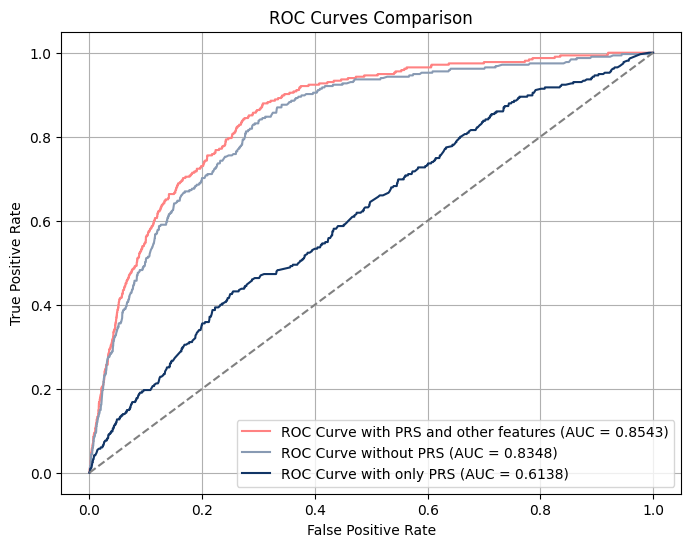

In [777]:
plt.figure(figsize=(8, 6))  

plt.plot(fpr_with_prs, tpr_with_prs, label=f'ROC Curve with PRS and other features (AUC = {roc_auc_with_prs:.4f})', color='#FF8282')
plt.plot(fpr_no_prs, tpr_no_prs, label=f'ROC Curve without PRS (AUC = {roc_auc_no_prs:.4f})', color='#889AB3')
plt.plot(fpr_only_prs, tpr_only_prs, label=f'ROC Curve with only PRS (AUC = {roc_auc_only_prs:.4f})', color='#113566')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend(loc='lower right')  
plt.grid()
plt.savefig(os.path.join(plot_dir, 'roc_curves.png'), dpi=300)

plt.show()

### **Results**

In [776]:
df_results_sorted = df_results.copy()
df_results['gap_abs'] = (df_results['train_auc'] - df_results['test_auc']).abs()

df_results = df_results.sort_values('gap_abs').reset_index(drop=True).drop(columns='gap_abs') 
df_results

,model,train_auc,test_auc
0,XGBoost,0.8582,0.8543
1,XGBoost with all non-genomic features,0.8281,0.8330
2,XGBoost without PRS,0.8281,0.8348
3,CatBoost,0.8515,0.8614
4,Neural Network,0.8242,0.8348
5,ResNet,0.8231,0.8337
6,LogisticRegression,0.8447,0.8595
7,RandomForest,0.8718,0.8568
8,LGBM,0.8724,0.8555
9,XGBoost with only PRS,0.6454,0.6138


### **Shap values**

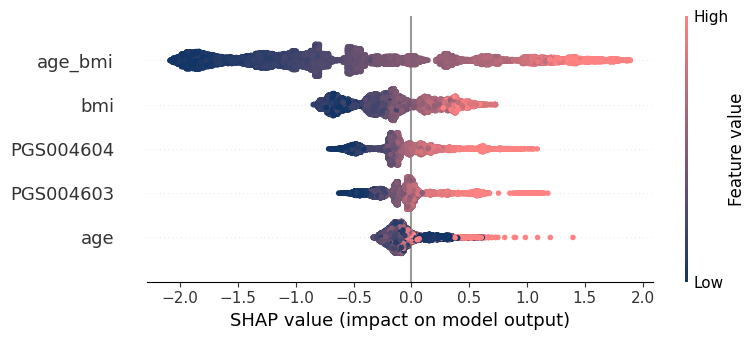

In [ ]:
import matplotlib.colors as mcolors

best_xgb_model.fit(X_train[xgb_selected_features], y_train)

explainer = shap.TreeExplainer(best_xgb_model)
shap_values = explainer.shap_values(X_test[xgb_selected_features])

plt.figure(figsize=(12, 8))
cmap_=mcolors.LinearSegmentedColormap.from_list('mycmap', ['#113566','#FF8282'])  
plt.savefig(os.path.join(plot_dir, 'shap.png'), dpi=300)
shap.summary_plot(shap_values, X_test[xgb_selected_features], max_display=10, cmap=cmap_)

### **Ethnicity-Stratified Analysis**

In [163]:
ethnic_counts = []

for ethnicity in ethnic_features:
    sub_df = df[df[ethnicity] > 0.5]
    
    total = len(sub_df)
    hypertensive = sub_df['hypertension'].sum()  
    prevalence = hypertensive / total if total > 0 else 0
    
    ethnic_counts.append({
        'Ethnicity': ethnicity,
        'Total': total,
        'Hypertensive': hypertensive,
        'Prevalence': round(prevalence, 3)
    })

result_df = pd.DataFrame(ethnic_counts)
result_df = result_df.sort_values(by='Hypertensive', ascending=False)
result_df

,Ethnicity,Total,Hypertensive,Prevalence
0,Central-Russia,96408,1474,0.015
3,Rejected,50034,770,0.015
7,Volga,31040,478,0.015
6,Finns,9927,162,0.016
2,Jews,8998,130,0.014
8,Baltic,8003,128,0.016
5,Eastern-Europe,7727,92,0.012
4,Western-Europe,4737,64,0.014
10,Central-Asia,5145,60,0.012
9,Western-Asia,7230,55,0.008


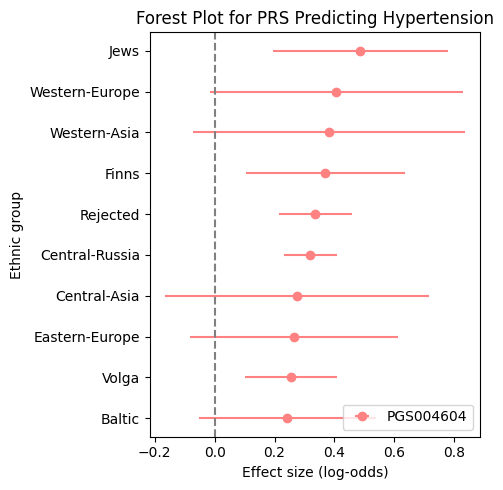

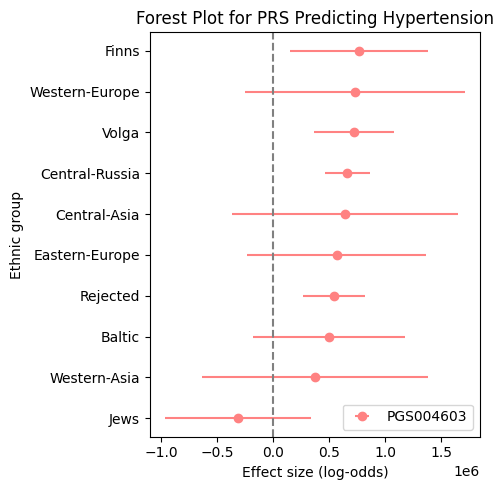

In [176]:
results = []

for ethnicity in ethnic_features: 
    subset = df[df[ethnicity] > 0.5]

    if subset['hypertension'].sum() < 50:
        continue
    
    try:
        model = sm.GLM(
            subset['hypertension'],
            sm.add_constant(subset[['age', 'bmi', 'age_bmi', 'PGS004604', 'PGS004603']]),
            family=sm.families.Binomial()
        ).fit()
        
        for prs in ['PGS004604', 'PGS004603']:
            coef = model.params[prs]
            stderr = model.bse[prs]
            pval = model.pvalues[prs]
            
            results.append({
                'Ethnicity': ethnicity,
                'PRS': prs,
                'Coef': coef,
                'Lower_CI': coef - 1.96 * stderr,
                'Upper_CI': coef + 1.96 * stderr,
                'P': pval
            })
    
    except Exception as e:
        print(f"Skipping {ethnicity} due to error: {e}")
        continue

results_df = pd.DataFrame(results)
for prs_type in ['PGS004604', 'PGS004603']:
    plt.figure(figsize=(5, len(results_df) * 0.25))
    plot_data = results_df[results_df['PRS'] == prs_type].sort_values('Coef')
    plt.errorbar(
        plot_data['Coef'],
        plot_data['Ethnicity'],
        xerr=[
            plot_data['Coef'] - plot_data['Lower_CI'],
            plot_data['Upper_CI'] - plot_data['Coef']
        ],
        fmt='o',
        label=prs_type,
        color='#FF8282'
    )

    plt.axvline(0, color='grey', linestyle='--')
    plt.xlabel('Effect size (log-odds)')
    plt.ylabel('Ethnic group')
    plt.title('Forest Plot for PRS Predicting Hypertension')
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(plot_dir, f'{prs_type}_forest_plot.png'), dpi=300)
    plt.show()